In [1]:
from CNN_2dhist_function import *

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


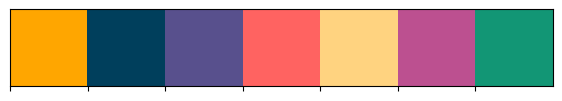

In [2]:
# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

# Obtén el número de CPUs
num_cpus = psutil.cpu_count(logical=False)

path_data = "/home/nicolas/nico/Data/data_Paper_OGLE/"

datos = f"{path_data}Data/datos_ogle/datos"

path_datos_4 = datos + "/datos_ogle_4/I"

path_datos_3 = datos + "/datos_ogle_3/I"
path_datos = ["_","_","_",path_datos_3,path_datos_4]

rng = np.random.default_rng(42)

gyr = ["#ffa600",
        '#003f5c',
       "#58508d",
       "#ff6361",
       "#ffd380",
       "#bc5090",
       "#129675"
      ]
palet = sns.palplot(sns.color_palette(gyr))
sns.set_context("paper")
path = "/home/nicolas/nico/Data/data_Paper_OGLE/7_01_2024/"

In [3]:

catalog = pd.read_csv(f"{path}/0_catalogo.csv")

In [4]:
%%time
results_ids = []
for i in range(len(catalog)):
    results_ids.append(review_open_data.remote(catalog["ID"][i],path_datos,catalog["database"][i]))                                                                                                               

2024-02-07 17:27:38,098	INFO worker.py:1621 -- Started a local Ray instance.


(pid=353100) review_open_data
CPU times: user 15min 11s, sys: 2min 11s, total: 17min 22s
Wall time: 7min 54s


In [5]:
%%time
df = pd.DataFrame(ray.get(results_ids),columns=["error",
                                            "ID", "database",
                                        "obs_eliminadas",
                                        "amplitud",
                                        "mag_mean",
                                        "mag_std",
                                        "err_mean",
                                        "err_std",
                                        "obs_final",
                                        "obs_inicial","baseline","cadence","cadence_sigma"])

CPU times: user 27.6 s, sys: 503 ms, total: 28.1 s
Wall time: 27.4 s


In [8]:
catalog = catalog[['ID', 'RA', 'DEC', 'types', 'database', 'field', 'Subtype', 'per']].merge(df,how="inner",on=["ID","database"])

In [57]:
a, b = ra_dec_to_degrees(catalog["RA"],catalog["DEC"])

In [58]:
catalog["ra_deg"] = a
catalog["dec_deg"] = b

In [4]:
df = pd.read_csv(f"{path}/0_Catalog_TimeSerieInformation.csv")

In [59]:
catalog.to_csv(f"{path}/0_Catalog_TimeSerieInformation.csv",index=False)

## Check Download

In [145]:
catalog = pd.read_csv(f"{path}/0_Catalog_TimeSerieInformation.csv")

In [68]:
error_descarga = catalog.loc[catalog["error"]==0]

In [14]:
%%time
error_descarga["descarga_wget"] = error_descarga.apply(lambda row: descarga_wget(row["database"],
                                                                       row["ID"],
                                                                      path_datos_3,
                                                                      path_datos_4),axis=1)

100% [..............................................................] 453 / 453CPU times: user 27.8 s, sys: 11.2 s, total: 39.1 s
Wall time: 7min


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [69]:
error_descarga[['ID', 'RA', 'DEC', 'types', 'database', 'field', 'Subtype', 'per']].to_csv(f"{path}/I_filter_data_missing.csv",index=False)

## Preprocesing

In [137]:
catalog = pd.read_csv(f"{path}/0_Catalog_TimeSerieInformation.csv")

In [138]:
df = catalog.groupby("types").count()[["ID"]].rename(columns={"ID":"Catalogo"})

In [139]:
catalog = catalog.loc[catalog["error"]!=0]

In [140]:
df["error download"] = df[["Catalogo"]].rename(columns={"Catalogo":"ID"}) - catalog.groupby("types").count()[["ID"]]

In [141]:
quantile_1_percent = catalog['obs_final'].quantile(0.01)
quantile_99_percent = catalog['obs_final'].quantile(0.8933)

print("1% Quantile:", quantile_1_percent)
print("89% Quantile:", quantile_99_percent)


1% Quantile: 64.0
89% Quantile: 2008.0


In [142]:
df["Observaciones<60"] = catalog.loc[(catalog["obs_final"]<=60)|
                                     (catalog["obs_final"]==0)
                                    ].groupby("types").count()[["ID"]]

In [143]:
catalog = catalog.loc[(catalog["obs_final"]>60)]

Text(0.5, 1.0, 'Percentage of Eliminated Observation \n mean 0.64 %')

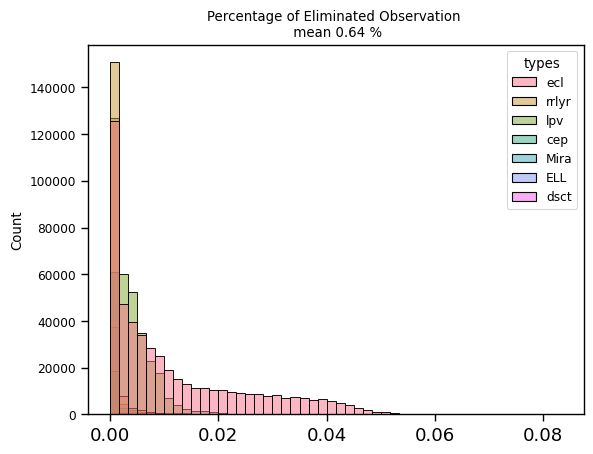

In [144]:
sns.histplot(data=catalog,x=catalog["obs_eliminadas"] / catalog["obs_inicial"],bins=50,hue="types")
mean_sigma_clipping = round((catalog["obs_eliminadas"] / catalog["obs_inicial"]).mean() * 100,2)
plt.title(f"Percentage of Eliminated Observation \n mean {mean_sigma_clipping} %")


In [145]:
catalog = catalog.sort_values(by="database",ascending=False).reset_index(drop=True)

In [146]:
df["Duplicated ID"] = catalog.loc[catalog.duplicated(subset="ID")].groupby("types").count()[["ID"]]

In [147]:
catalog = catalog.drop_duplicates(subset="ID",keep="first").reset_index(drop=True)

In [148]:
catalog.to_csv(f"{path}/0_Catalog_TimeSerieInformation_AT.csv",index=False)

In [149]:
catalog = pd.read_csv(f"{path}/0_Catalog_TimeSerieInformation_AT.csv")

In [150]:
catalog_t = pd.read_csv(f"{path}/0_Catalog_TimeSerieInformation_DT.csv")

In [151]:
catalog_t.loc[catalog_t["GroupID"].notna()].to_csv(f"{path}/0_Catalog_TimeSerieInformation_DT_possible_blended.csv",index=False)

In [152]:
catalog_t = catalog_t.loc[catalog_t["GroupID"].isna()]

In [153]:
catalog_t.to_csv(f"{path}/0_Catalog_TimeSerieInformation_DT_unique.csv",index=False)

In [154]:
df["Topcat"] = catalog.groupby("types").count()[["ID"]] - catalog_t.groupby("types").count()[["ID"]]

In [155]:
df["final"] = catalog_t.groupby("types").count()[["ID"]]

In [156]:
df = df.fillna(0)


In [3]:
path_save = "/home/nicolas/nico/Data/data_Paper_OGLE/7_01_2024/"
catalog = pd.read_csv(f"{path_save}/0_Catalog_TimeSerieInformation_DT_unique.csv")

In [4]:
catalog = catalog.loc[(catalog["per"]!=0)&(catalog["per"].notna())] # one ECL star without period and 15 with nans

In [5]:
cep_min = catalog.groupby("types").count().sort_values(by="ID",ascending=True)["ID"].values[0]

In [61]:
df_split_random = split_random(catalog,cep_min,"Train_8")

In [62]:
train_8 = df_split_random.loc[df_split_random["Train_8"].notna()]

In [63]:
df_split_random.to_csv(f"{path}/0_Catalog_TimeSerieInformation_DT_Train_8.csv",index=False)

## Augmented data

In [65]:
ogle = pd.read_csv(f"{path}/0_Catalog_TimeSerieInformation_DT_Train_8.csv")
le = preprocessing.LabelEncoder()
le.fit(ogle.types)
ogle["categorical_label"] = le.transform(ogle.types)
prueba_8mil = ogle.loc[ogle["Train_8"].notna()]

In [66]:
ogle, train_number_ELL = balance_data(ogle, prueba_8mil)

In [67]:
ogle, train_number_DST = balance_data(ogle, train_number_ELL)

In [68]:
ogle, train_number_M = balance_data(ogle, train_number_DST)

In [69]:
train_number_ELL,_ = data_augmented_parameter_creator(train_number_ELL)
train_number_DST,_ = data_augmented_parameter_creator(train_number_DST)
train_number_M,_ = data_augmented_parameter_creator(train_number_M)

*** SIGTERM received at time=1704732159 on cpu 31 ***
*** SIGTERM received at time=1704732159 on cpu 2 ***
*** SIGTERM received at time=1704732159 on cpu 16 ***
*** SIGTERM received at time=1704732159 on cpu 25 ***
*** SIGTERM received at time=1704732159 on cpu 19 ***
*** SIGTERM received at time=1704732159 on cpu 21 ***
*** SIGTERM received at time=1704732159 on cpu 24 ***
*** SIGTERM received at time=1704732159 on cpu 6 ***
*** SIGTERM received at time=1704732159 on cpu 5 ***
*** SIGTERM received at time=1704732159 on cpu 18 ***
*** SIGTERM received at time=1704732159 on cpu 11 ***
*** SIGTERM received at time=1704732159 on cpu 26 ***
*** SIGTERM received at time=1704732159 on cpu 27 ***
PC: @     0x7444aef1462c  (unknown)  __read
PC: @     0x7444aef1462c  (unknown)  __read
PC: @     0x7444aef1462c  (unknown)  __read
PC: @     0x7444aef1462c  (unknown)  __read
    @     0x7444aee42520  (unknown)  (unknown)
    @     0x7444aee42520  (unknown)  (unknown)
    @     0x7444aee42520  (unkn

(raylet) [2024-01-08 13:42:57,780 E 94806 94806] (raylet) node_manager.cc:3084: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 1bd60255965726019a8590a38e1413810347966c5b12397592f8f2ee, IP: 172.16.40.127) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.16.40.127`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
*** SIGTERM received at time=1704732192 on cpu 28 ***
*** SIGTERM received at time=1704732192 on cpu 31 ***
*** SIG

(raylet) [2024-01-08 13:43:57,780 E 94806 94806] (raylet) node_manager.cc:3084: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 1bd60255965726019a8590a38e1413810347966c5b12397592f8f2ee, IP: 172.16.40.127) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.16.40.127`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


In [70]:
catalog = pd.read_csv(f"{path}/0_Catalog_TimeSerieInformation_DT_Train_8.csv")


In [71]:
catalog.loc[(catalog["ID"].isin(train_number_ELL["ID"]))&
               catalog["Train_8"].isna(),"Train_NumberELL"] = "train"

In [72]:
catalog.loc[(catalog["ID"].isin(train_number_DST["ID"]))&
               catalog["Train_8"].isna(),"Train_NumberDST"] = "train"

In [73]:
catalog.loc[(catalog["ID"].isin(train_number_M["ID"]))&
               catalog["Train_8"].isna(),"Train_NumberM"] = "train"

In [74]:
prueba_8mil["aug"] = 0
prueba_8mil["g"] = np.nan
prueba_8mil["bins"] = np.nan

catalog["aug"] = 0
catalog["g"] = np.nan
catalog["bins"] = np.nan


In [75]:
prueba_8mil_2 = make_random_period(prueba_8mil)
train_number_ELL =  make_random_period(train_number_ELL,train_number_ELL.groupby("categorical_label")["ID"].count().max())
train_number_DST =  make_random_period(train_number_DST,train_number_DST.groupby("categorical_label")["ID"].count().max())
train_number_M =  make_random_period(train_number_M,train_number_M.groupby("categorical_label")["ID"].count().max())

In [76]:
train_number_M.groupby(["categorical_label","types"]).count()

ID     RA    DEC  database  field  Subtype  \
categorical_label types                                                         
0                 ELL           60318  60318  60318     60318  60318        0   
1                 Mira          60318  60318  60318     60318  60318    57184   
2                 cep           60318  60318  60318     60318  60318    60318   
3                 dsct          60318  60318  60318     60318  60318    60318   
4                 ecl           60318  60318  60318     60318  60318    60318   
5                 lpv           60318  60318  60318     60318  60318    60318   
6                 rrlyr         60318  60318  60318     60318  60318    60318   
7                 ELL_random     8652   8652   8652      8652   8652        0   
                  Mira_random    8652   8652   8652      8652   8652     8204   
                  cep_random     8404   8404   8404      8404   8404     8404   
                  dsct_random    8653   8653   8653      8653   8653     8653   
                  ecl_random     8653   8653   8653      8653   8653     8653   
                  lpv_random     8652   8652   8652      8652   8652     8652   
                  rrlyr_random   8652   8652   8652      8652   8652     8652   

                                  per  error  obs_eliminadas  amplitud  ...  \
categorical_label types                                                 ...   
0                 ELL           60318  60318           60318     60318  ...   
1                 Mira          60318  60318           60318     60318  ...   
2                 cep           60318  60318           60318     60318  ...   
3                 dsct          60318  60318           60318     60318  ...   
4                 ecl           60318  60318           60318     60318  ...   
5                 lpv           60318  60318           60318     60318  ...   
6                 rrlyr         60318  60318           60318     60318  ...   
7                 ELL_random     8652   8652            8652      8652  ...   
                  Mira_random    8652   8652            8652      8652  ...   
                  cep_random     8404   8404            8404      8404  ...   
                  dsct_random    8653   8653            8653      8653  ...   
                  ecl_random     8653   8653            8653      8653  ...   
                  lpv_random     8652   8652            8652      8652  ...   
                  rrlyr_random   8652   8652            8652      8652  ...   

                                baseline  ra_deg  dec_deg  GroupID  GroupSize  \
categorical_label types                                                         
0                 ELL              60318   60318    60318        0          0   
1                 Mira             60318   60318    60318        0          0   
2                 cep              60318   60318    60318        0          0   
3                 dsct             60318   60318    60318        0          0   
4                 ecl              60318   60318    60318        0          0   
5                 lpv              60318   60318    60318        0          0   
6                 rrlyr            60318   60318    60318        0          0   
7                 ELL_random        8652    8652     8652        0          0   
                  Mira_random       8652    8652     8652        0          0   
                  cep_random        8404    8404     8404        0          0   
                  dsct_random       8653    8653     8653        0          0   
                  ecl_random        8653    8653     8653        0          0   
                  lpv_random        8652    8652     8652        0          0   
                  rrlyr_random      8652    8652     8652        0          0   

                                Train_8    aug  count   bins      g  
categorical_label types                                              
0                 ELL             60

In [77]:
train_number_ELL.to_csv(f"{path}/train_number_ELL.csv",index=False)
train_number_DST.to_csv(f"{path}/train_number_DST.csv",index=False)
train_number_M.to_csv(f"{path}/train_number_M.csv",index=False)
prueba_8mil_2.to_csv(f"{path}/prueba_8mil.csv",index=False)
catalog.to_csv(f"{path}/0_Catalog_TimeSerieInformation_DT_Augmented.csv",index=False)

## Plots

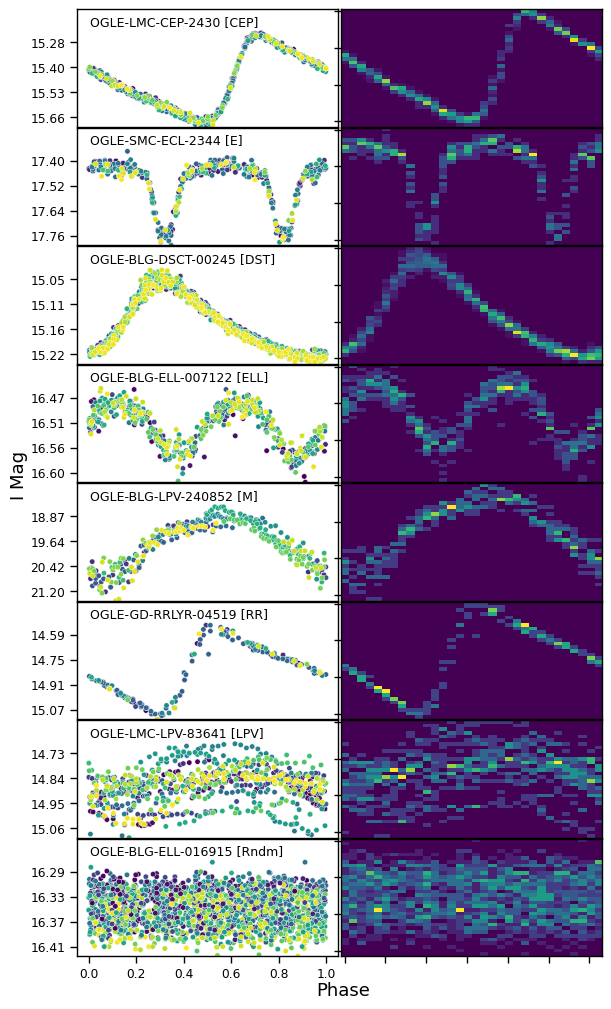

In [4]:
estrellas = ['OGLE-GD-RRLYR-04519', 'OGLE-BLG-LPV-240852', "OGLE-SMC-ECL-2344", "OGLE-LMC-CEP-2430", 'OGLE-LMC-LPV-83641', "OGLE-BLG-DSCT-00245", "OGLE-BLG-ELL-007122"]


catalog = pd.read_csv(f"{path}/0_Catalog_TimeSerieInformation_DT_unique.csv")
catalog = catalog.loc[catalog["per"]!=0]

estrellas_plot = catalog.loc[catalog["ID"].isin(estrellas)].reset_index(drop=True)

random = pd.read_csv(f"{path}/train_number_M.csv")
rndm = random.loc[random["categorical_label"]==7].sample(1).reset_index(drop=True)
rndm["types"]="Random"

estrellas_plot = pd.concat([estrellas_plot,rndm]).reset_index(drop=True)

replacement_dict = {
    "cep": "CEP",
    "ecl": "E",
    "dsct": "DST",
    "ELL": "ELL",
    "Mira": "M",
    "rrlyr": "RR",
    "lpv": "LPV",
    "Random": "Rndm"
}

estrellas_plot["types"] = estrellas_plot["types"].replace(replacement_dict)

a = plot_histograms(estrellas_plot, path_datos,"max",path)

In [6]:
train_8 = pd.read_csv(f"{path}/0_Catalog_TimeSerieInformation_DT_Train_8.csv")

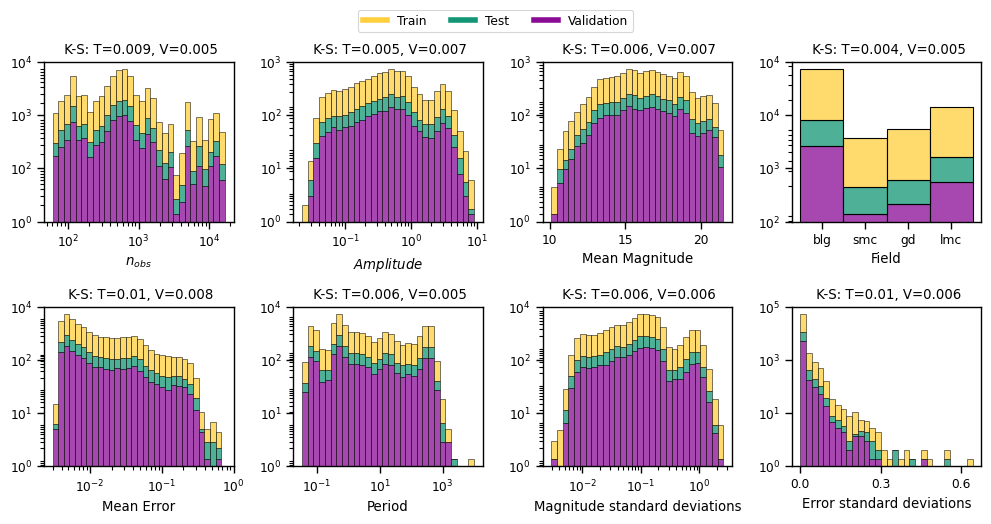

0.01

In [63]:
plot_obs_dist(train_8,"Train_8",path)

### Hacer HDF5 

In [21]:
ray.init()

2024-02-10 16:48:13,506	WARNING services.py:1832 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-02-10 16:48:13,653	INFO worker.py:1621 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.11.0', ray_version='2.6.1', ray_commit='d68bf04883af2e430fc3a50fd544bb7c84aff2e9', protocol_version=None)

In [22]:
train_number_ELL = pd.read_csv(f"{path}/train_number_ELL.csv")
train_number_DST = pd.read_csv(f"{path}/train_number_DST.csv")
train_number_M = pd.read_csv(f"{path}/train_number_M.csv")
prueba_8mil = pd.read_csv(f"{path}/prueba_8mil.csv")
ogle = pd.read_csv(f"{path}/0_Catalog_TimeSerieInformation_DT_Augmented.csv")

In [83]:
data_total = h5py.File(f'{path}/Data.hdf5', 'w')
for test,name  in zip([prueba_8mil,
                       train_number_ELL,
                       train_number_DST,
                       train_number_M],["Number_CEP","Number_ELL",
                                                                 "Number_DST",
                                                                 "Number_M"]):
    data_hist = create_hdf5(test,path_datos,rng)
    data_total.create_dataset(f'{str(name)}_label', data=test['categorical_label'])
    data_total.create_dataset(f'{str(name)}_data', data=data_hist)

(pid=97709) INFO: Pandarallel will run on 24 workers.
(pid=97709) INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
(pid=98628) INFO: Pandarallel will run on 24 workers. [repeated 32x across cluster]
(pid=98628) INFO: Pandarallel will use Memory file system to transfer data between the main process and workers. [repeated 32x across cluster]
(pid=98680) INFO: Pandarallel will run on 24 workers.
(pid=98680) INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


(make pid=97719) _lc_hist


In [85]:
data_total.close()

In [86]:
data_hist = create_hdf5(ogle,path_datos,rng)
OGLE = h5py.File(f'{path}/OGLE.hdf5', 'w')
OGLE.create_dataset(f'{path}/OGLE_label', data=ogle['categorical_label'])
OGLE.create_dataset(f'{path}/OGLE_images', data=data_hist)

(make_lc_hist pid=97691) :task_n
(make_lc_hist pid=97691) ame:make_lc_hist


(pid=99157) INFO: Pandarallel will run on 24 workers.
(pid=99157) INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
(pid=99158) INFO: Pandarallel will run on 24 workers.
(pid=99158) INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


(raylet) [2024-01-08 14:13:27,667 E 97605 97605] (raylet) node_manager.cc:3084: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: a50eec9399451e08095e2997de07ee51b11d5f6e6026b0e4c83ffc9e, IP: 172.16.40.127) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.16.40.127`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(pid=99217) INFO: Pandarallel will run on 24 workers.
(pid=99217) INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
(pid=99218) INFO: Pandarallel will run on 24 workers.
(pid=99218) INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
(pid=99278) INFO: Pandarallel will run on 24 workers.
(pid=99278) INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


(raylet) [2024-01-08 14:14:27,668 E 97605 97605] (raylet) node_manager.cc:3084: 5 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: a50eec9399451e08095e2997de07ee51b11d5f6e6026b0e4c83ffc9e, IP: 172.16.40.127) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.16.40.127`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2024-01-08 14:16:27,669 E 97605 97605] (raylet) node_manager.cc:3084: 13 Workers (tasks / actors) killed 

In [101]:
data_total.close()

In [100]:
OGLE.close()

/tmp/ipykernel_811717/106567221.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["phi"] = df_plot["g"] / df_plot["per"]
/tmp/ipykernel_811717/106567221.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["phi"] = df_plot["g"] / df_plot["per"]
/tmp/ipykernel_811717/106567221.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

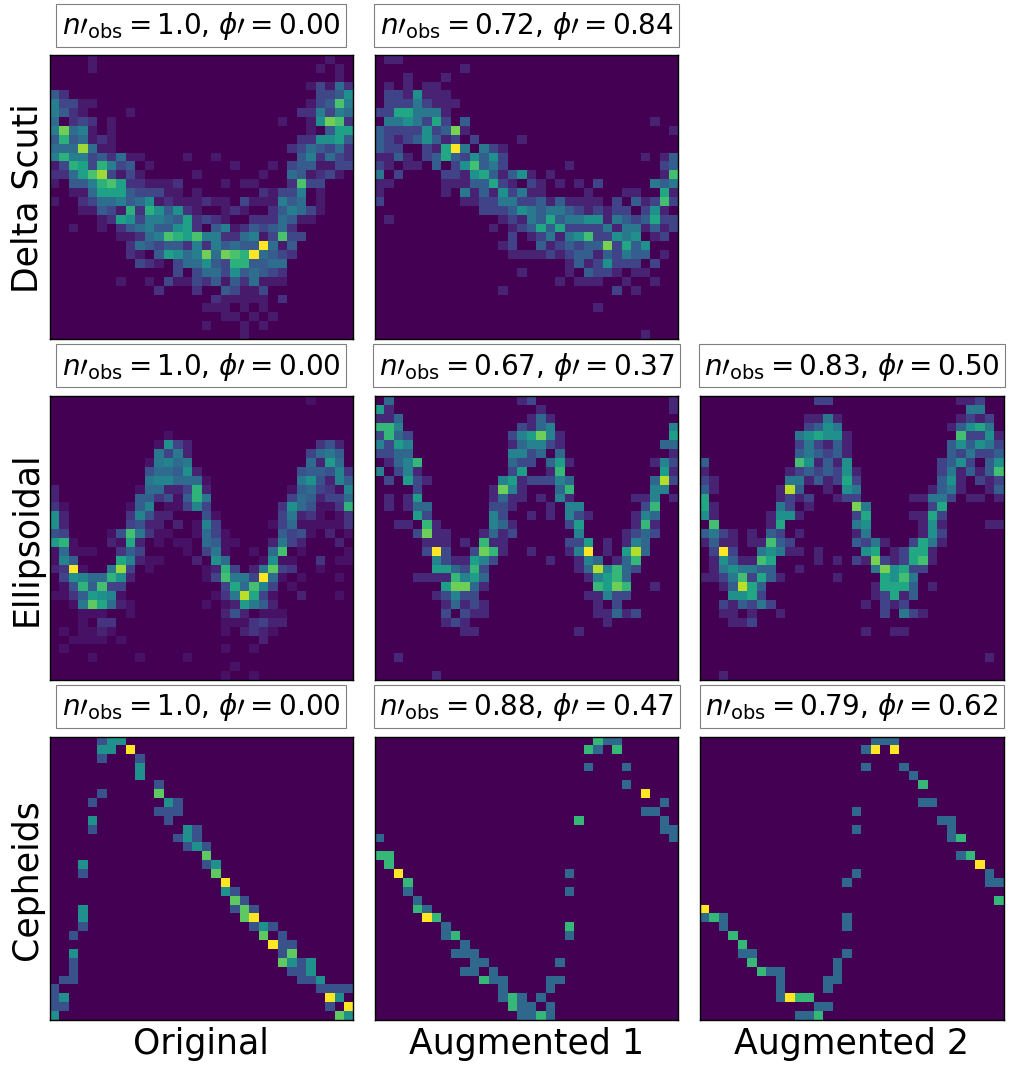

In [5]:
df = pd.read_csv(f"{path}/train_number_M.csv")
data = h5py.File(f"{path}Data.hdf5", 'r+')
ID_cep = 'OGLE-GD-CEP-0028'
ID_dsct = 'OGLE-BLG-DSCT-08845'
ID_ELL = 'OGLE-BLG-ELL-016777'
# Creación de la figura y los ejes
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
plt.tight_layout(pad=0.2)

# Ciclo para cada grupo de estrellas
for fila, stars_group in enumerate([ID_dsct,ID_ELL, ID_cep]):
    df_plot = df.loc[(df["ID"] == stars_group) & (df["types"].str.split("_").str[1] != "random")]
    df_plot.loc[df_plot["bins"].isna(), "bins"] = df_plot["obs_final"]
    df_plot.loc[df_plot["aug"] == 0, "g"] = 0
    df_plot["phi"] = df_plot["g"] / df_plot["per"]
    df_plot = df_plot.sort_values(by="phi")
    df_plot.loc[df_plot["types"] == "cep", "types"] = "Cepheids"
    df_plot.loc[df_plot["types"] == "dsct", "types"] = "Delta Scuti"
    df_plot.loc[df_plot["types"] == "ELL", "types"] = "Ellipsoidal"
    
    for col, star in enumerate(df_plot.index):
        fill_subplot(axes[fila, col], df_plot, star, data)
        axes[fila, col].set_yticks([])
        if col == 0:
            axes[fila, col].set_ylabel(df_plot.loc[star]["types"], fontsize=25)

        if (col == 0) & (fila == 2):
            axes[fila, col].set_xlabel("Original", fontsize=25)
        if (col != 0) & (fila == 2):
            axes[fila, col].set_xlabel(f"Augmented {col}", fontsize=25)

        axes[fila, col].set_xticks([])
    
    # Eliminar los ejes vacíos
    for col in range(len(df_plot.index), 3):
        fig.delaxes(axes[fila, col])

plt.subplots_adjust(hspace=0.2)
plt.savefig(f"{path}Augmented_stars.pdf", bbox_inches="tight")
plt.show()

## Time to Create 2d Histograms

In [8]:
ray.init()


2024-02-23 14:16:57,648	INFO worker.py:1621 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.8.18', ray_version='2.6.1', ray_commit='d68bf04883af2e430fc3a50fd544bb7c84aff2e9', protocol_version=None)

In [9]:
prueba_8mil = pd.read_csv(f"{path}/prueba_8mil.csv")

In [10]:
t0 = time.time()
data_hist = create_hdf5(prueba_8mil.reset_index(drop=True),path_datos,rng)
t1 = time.time() - t0

(pid=396185) INFO: Pandarallel will run on 24 workers.
(pid=396185) INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
(pid=397118) INFO: Pandarallel will run on 24 workers. [repeated 32x across cluster]
(pid=397118) INFO: Pandarallel will use Memory file system to transfer data between the main process and workers. [repeated 32x across cluster]
(pid=397148) INFO: Pandarallel will run on 24 workers.
(pid=397148) INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [13]:
t1

50.44752264022827

In [20]:
ogle = pd.read_csv(f"{path}/0_Catalog_TimeSerieInformation_DT_Augmented.csv")
df = ogle.sample(10000).reset_index(drop=True)

In [96]:
result = np.zeros((10000,3,2))
for i in range(10000):
    _,b = make_lc_hist_with_time(df["ID"][i],df["per"][i],
                                  path_datos,
                                  df["database"][i],
                                  df["aug"][i],
                                  rng,
                                  df["g"][i],
                                  df["bins"][i])
    result[i] = b[["time","percentage"]].values

           task      time  percentage
0      load_csv  0.002520   54.336984
1  Prepare Data  0.001148   24.762199
2     histogram  0.000968   20.864826
           task      time  percentage
0      load_csv  0.000941   34.135156
1  Prepare Data  0.000977   35.450376
2     histogram  0.000836   30.353898
           task      time  percentage
0      load_csv  0.000893   33.596483
1  Prepare Data  0.000977   36.754284
2     histogram  0.000786   29.586436
           task      time  percentage
0      load_csv  0.002181   46.272129
1  Prepare Data  0.001592   33.773394
2     histogram  0.000939   19.919069
           task      time  percentage
0      load_csv  0.000697   29.247075
1  Prepare Data  0.000896   37.586241
2     histogram  0.000789   33.086691
           task      time  percentage
0      load_csv  0.000773   31.381280
1  Prepare Data  0.000904   36.685703
2     histogram  0.000784   31.836221
           task      time  percentage
0      load_csv  0.000998   35.281221
1  Prepare D

           task      time  percentage
0      load_csv  0.001103   37.797206
1  Prepare Data  0.001024   35.084566
2     histogram  0.000789   27.052864
           task      time  percentage
0      load_csv  0.000774   31.752396
1  Prepare Data  0.000892   36.583219
2     histogram  0.000770   31.586153
           task      time  percentage
0      load_csv  0.001862   43.978822
1  Prepare Data  0.001484   35.068154
2     histogram  0.000885   20.907964
           task      time  percentage
0      load_csv  0.000883   33.730990
1  Prepare Data  0.000937   35.798197
2     histogram  0.000796   30.416173
           task      time  percentage
0      load_csv  0.000643   28.208346
1  Prepare Data  0.000883   38.719799
2     histogram  0.000752   32.998640
           task      time  percentage
0      load_csv  0.000719   30.052794
1  Prepare Data  0.000901   37.653153
2     histogram  0.000772   32.244247
           task      time  percentage
0      load_csv  0.000649   28.574426
1  Prepare D

           task      time  percentage
0      load_csv  0.003348   52.276535
1  Prepare Data  0.002148   33.535609
2     histogram  0.000907   14.161796
           task      time  percentage
0      load_csv  0.001020   35.744112
1  Prepare Data  0.000984   34.474695
2     histogram  0.000849   29.722733
           task      time  percentage
0      load_csv  0.000702   29.687500
1  Prepare Data  0.000906   38.296371
2     histogram  0.000755   31.935484
           task      time  percentage
0      load_csv  0.000686   29.208122
1  Prepare Data  0.000907   38.609137
2     histogram  0.000754   32.111675
           task      time  percentage
0      load_csv  0.000805   31.879543
1  Prepare Data  0.000922   36.514680
2     histogram  0.000797   31.549136
           task      time  percentage
0      load_csv  0.000869   33.734605
1  Prepare Data  0.000913   35.466247
2     histogram  0.000791   30.725067
           task      time  percentage
0      load_csv  0.000996   35.703906
1  Prepare D

           task      time  percentage
0      load_csv  0.001149   40.144891
1  Prepare Data  0.000921   32.150887
2     histogram  0.000791   27.637605
           task      time  percentage
0      load_csv  0.001435   39.907193
1  Prepare Data  0.001274   35.432549
2     histogram  0.000885   24.607226
           task      time  percentage
0      load_csv  0.000801   31.572516
1  Prepare Data  0.000938   36.986559
2     histogram  0.000796   31.375129
           task      time  percentage
0      load_csv  0.003218   54.418998
1  Prepare Data  0.001788   30.235465
2     histogram  0.000905   15.309249
           task      time  percentage
0      load_csv  0.000700   29.915401
1  Prepare Data  0.000887   37.916624
2     histogram  0.000751   32.086434
           task      time  percentage
0      load_csv  0.000688   29.479710
1  Prepare Data  0.000884   37.882040
2     histogram  0.000760   32.566697
           task      time  percentage
0      load_csv  0.000698   29.950900
1  Prepare D

           task      time  percentage
0      load_csv  0.000956   31.756971
1  Prepare Data  0.000961   31.939163
2     histogram  0.001090   36.224651
           task      time  percentage
0      load_csv  0.000927   36.096157
1  Prepare Data  0.000885   34.462595
2     histogram  0.000755   29.385558
           task      time  percentage
0      load_csv  0.000843   32.786125
1  Prepare Data  0.000908   35.327398
2     histogram  0.000818   31.812280
           task      time  percentage
0      load_csv  0.000946   34.911972
1  Prepare Data  0.000946   34.929577
2     histogram  0.000815   30.096831
           task      time  percentage
0      load_csv  0.000729   30.648232
1  Prepare Data  0.000890   37.381024
2     histogram  0.000759   31.910630
           task      time  percentage
0      load_csv  0.000663   29.114322
1  Prepare Data  0.000874   38.389866
2     histogram  0.000738   32.422529
           task      time  percentage
0      load_csv  0.000658   29.048221
1  Prepare D

           task      time  percentage
0      load_csv  0.000725   26.383828
1  Prepare Data  0.000902   32.838799
2     histogram  0.001119   40.716641
           task      time  percentage
0      load_csv  0.001060   38.404421
1  Prepare Data  0.000911   32.990848
2     histogram  0.000788   28.527025
           task      time  percentage
0      load_csv  0.002829   53.682258
1  Prepare Data  0.001524   28.924274
2     histogram  0.000915   17.357279
           task      time  percentage
0      load_csv  0.001047   36.941711
1  Prepare Data  0.000951   33.552023
2     histogram  0.000834   29.438977
           task      time  percentage
0      load_csv  0.000783   32.123643
1  Prepare Data  0.000903   37.063484
2     histogram  0.000749   30.744400
           task      time  percentage
0      load_csv  0.000654   29.125491
1  Prepare Data  0.000859   38.284986
2     histogram  0.000729   32.504516
           task      time  percentage
0      load_csv  0.000715   30.414513
1  Prepare D

           task      time  percentage
0      load_csv  0.000643   25.724914
1  Prepare Data  0.000862   34.490652
2     histogram  0.000993   39.717665
           task      time  percentage
0      load_csv  0.001197   39.767055
1  Prepare Data  0.000985   32.731162
2     histogram  0.000826   27.438396
           task      time  percentage
0      load_csv  0.000719   29.499853
1  Prepare Data  0.000925   37.985710
2     histogram  0.000790   32.426348
           task      time  percentage
0      load_csv  0.000983   34.985151
1  Prepare Data  0.000974   34.662707
2     histogram  0.000851   30.292745
           task      time  percentage
0      load_csv  0.000951   34.899799
1  Prepare Data  0.000928   34.077186
2     histogram  0.000844   30.970508
           task      time  percentage
0      load_csv  0.000649   28.882053
1  Prepare Data  0.000865   38.502333
2     histogram  0.000732   32.551973
           task      time  percentage
0      load_csv  0.000878   33.643836
1  Prepare D

           task      time  percentage
0      load_csv  0.000942   30.790806
1  Prepare Data  0.000946   30.915466
2     histogram  0.001170   38.223607
           task      time  percentage
0      load_csv  0.000872   33.458303
1  Prepare Data  0.000939   36.027798
2     histogram  0.000794   30.459034
           task      time  percentage
0      load_csv  0.000646   28.677249
1  Prepare Data  0.000855   37.936508
2     histogram  0.000750   33.301587
           task      time  percentage
0      load_csv  0.000834   32.722342
1  Prepare Data  0.000917   35.967455
2     histogram  0.000796   31.226036
           task      time  percentage
0      load_csv  0.000842   32.703704
1  Prepare Data  0.000928   36.027778
2     histogram  0.000804   31.212963
           task      time  percentage
0      load_csv  0.000794   31.872967
1  Prepare Data  0.000910   36.493208
2     histogram  0.000787   31.566864
           task      time  percentage
0      load_csv  0.000787   31.537727
1  Prepare D

           task      time  percentage
0      load_csv  0.001189   39.929555
1  Prepare Data  0.001005   33.757605
2     histogram  0.000782   26.248799
           task      time  percentage
0      load_csv  0.001042   37.409025
1  Prepare Data  0.000937   33.641579
2     histogram  0.000804   28.889460
           task      time  percentage
0      load_csv  0.000904   34.428610
1  Prepare Data  0.000924   35.172915
2     histogram  0.000796   30.307706
           task      time  percentage
0      load_csv  0.001314   37.833013
1  Prepare Data  0.001273   36.652019
2     histogram  0.000885   25.473771
           task      time  percentage
0      load_csv  0.000763   31.307497
1  Prepare Data  0.000913   37.482873
2     histogram  0.000758   31.131337
           task      time  percentage
0      load_csv  0.000653   28.774180
1  Prepare Data  0.000876   38.635408
2     histogram  0.000738   32.527334
           task      time  percentage
0      load_csv  0.000659   28.891213
1  Prepare D

           task      time  percentage
0      load_csv  0.000937   29.726048
1  Prepare Data  0.001376   43.665809
2     histogram  0.000837   26.570304
           task      time  percentage
0      load_csv  0.000737   31.091001
1  Prepare Data  0.000880   37.104072
2     histogram  0.000753   31.744595
           task      time  percentage
0      load_csv  0.000703   29.922858
1  Prepare Data  0.000885   37.657328
2     histogram  0.000760   32.348762
           task      time  percentage
0      load_csv  0.000730   30.423543
1  Prepare Data  0.000904   37.701332
2     histogram  0.000762   31.795586
           task      time  percentage
0      load_csv  0.000648   27.588307
1  Prepare Data  0.000895   38.103938
2     histogram  0.000804   34.246853
           task      time  percentage
0      load_csv  0.000698   29.732751
1  Prepare Data  0.000891   37.994106
2     histogram  0.000756   32.212174
           task      time  percentage
0      load_csv  0.000680   29.294589
1  Prepare D

           task      time  percentage
0      load_csv  0.000738   26.342667
1  Prepare Data  0.000929   33.160269
2     histogram  0.001133   40.437484
           task      time  percentage
0      load_csv  0.001069   36.782930
1  Prepare Data  0.000988   34.017234
2     histogram  0.000846   29.125975
           task      time  percentage
0      load_csv  0.003928   58.894609
1  Prepare Data  0.001827   27.395252
2     histogram  0.000912   13.681539
           task      time  percentage
0      load_csv  0.000856   32.818498
1  Prepare Data  0.000942   36.099433
2     histogram  0.000809   31.008956
           task      time  percentage
0      load_csv  0.000840   33.095283
1  Prepare Data  0.000912   35.933095
2     histogram  0.000784   30.915241
           task      time  percentage
0      load_csv  0.000812   32.639755
1  Prepare Data  0.000897   36.091667
2     histogram  0.000776   31.201457
           task      time  percentage
0      load_csv  0.000770   31.570716
1  Prepare D

           task      time  percentage
0      load_csv  0.000762   26.678917
1  Prepare Data  0.000930   32.592716
2     histogram  0.001160   40.644838
           task      time  percentage
0      load_csv  0.000754   31.250618
1  Prepare Data  0.000901   37.380129
2     histogram  0.000755   31.300049
           task      time  percentage
0      load_csv  0.000770   30.601611
1  Prepare Data  0.000938   37.280910
2     histogram  0.000807   32.060635
           task      time  percentage
0      load_csv  0.000731   30.448176
1  Prepare Data  0.000898   37.444102
2     histogram  0.000768   32.028222
           task      time  percentage
0      load_csv  0.000645   28.416851
1  Prepare Data  0.000882   38.880134
2     histogram  0.000741   32.629478
           task      time  percentage
0      load_csv  0.000741   30.278807
1  Prepare Data  0.000926   37.872880
2     histogram  0.000777   31.780074
           task      time  percentage
0      load_csv  0.000965   34.649311
1  Prepare D

           task      time  percentage
0      load_csv  0.000640   24.406872
1  Prepare Data  0.000869   33.142442
2     histogram  0.001111   42.359785
           task      time  percentage
0      load_csv  0.003990   56.276270
1  Prepare Data  0.002116   29.842967
2     histogram  0.000982   13.853862
           task      time  percentage
0      load_csv  0.000807   32.002649
1  Prepare Data  0.000917   36.392016
2     histogram  0.000794   31.520197
           task      time  percentage
0      load_csv  0.000764   30.900501
1  Prepare Data  0.000914   36.945623
2     histogram  0.000794   32.096028
           task      time  percentage
0      load_csv  0.000713   29.895979
1  Prepare Data  0.000896   37.567514
2     histogram  0.000774   32.476495
           task      time  percentage
0      load_csv  0.000768   30.885032
1  Prepare Data  0.000921   37.021766
2     histogram  0.000796   32.016492
           task      time  percentage
0      load_csv  0.001050   35.937628
1  Prepare D

           task      time  percentage
0      load_csv  0.000700   25.914149
1  Prepare Data  0.000897   33.227345
2     histogram  0.001101   40.779014
           task      time  percentage
0      load_csv  0.000855   33.955118
1  Prepare Data  0.000901   35.763659
2     histogram  0.000761   30.224411
           task      time  percentage
0      load_csv  0.000669   29.437684
1  Prepare Data  0.000861   37.903903
2     histogram  0.000741   32.584977
           task      time  percentage
0      load_csv  0.001019   36.349719
1  Prepare Data  0.000949   33.840789
2     histogram  0.000834   29.732948
           task      time  percentage
0      load_csv  0.003344   57.380134
1  Prepare Data  0.001587   27.233677
2     histogram  0.000894   15.345279
           task      time  percentage
0      load_csv  0.000960   35.222601
1  Prepare Data  0.000938   34.417913
2     histogram  0.000825   30.280766
           task      time  percentage
0      load_csv  0.000955   34.516324
1  Prepare D

           task      time  percentage
0      load_csv  0.002398   49.439583
1  Prepare Data  0.001553   32.022417
2     histogram  0.000897   18.498673
           task      time  percentage
0      load_csv  0.002300   49.793538
1  Prepare Data  0.001427   30.886755
2     histogram  0.000890   19.268091
           task      time  percentage
0      load_csv  0.000793   31.268215
1  Prepare Data  0.000957   37.755006
2     histogram  0.000784   30.901570
           task      time  percentage
0      load_csv  0.000935   33.959813
1  Prepare Data  0.000971   35.276286
2     histogram  0.000839   30.486749
           task      time  percentage
0      load_csv  0.000991   35.702011
1  Prepare Data  0.000948   34.163946
2     histogram  0.000834   30.056711
           task      time  percentage
0      load_csv  0.000956   34.464976
1  Prepare Data  0.000976   35.169746
2     histogram  0.000841   30.313709
           task      time  percentage
0      load_csv  0.000961   34.579760
1  Prepare D

           task      time  percentage
0      load_csv  0.001985   45.728726
1  Prepare Data  0.001469   33.840576
2     histogram  0.000885   20.392243
           task      time  percentage
0      load_csv  0.000904   34.301747
1  Prepare Data  0.000939   35.650285
2     histogram  0.000789   29.948412
           task      time  percentage
0      load_csv  0.001065   36.112908
1  Prepare Data  0.001005   34.082821
2     histogram  0.000877   29.755742
           task      time  percentage
0      load_csv  0.000657   28.732394
1  Prepare Data  0.000886   38.779343
2     histogram  0.000741   32.436098
           task      time  percentage
0      load_csv  0.000731   30.732197
1  Prepare Data  0.000880   37.041123
2     histogram  0.000764   32.156469
           task      time  percentage
0      load_csv  0.000720   29.973185
1  Prepare Data  0.000913   38.027609
2     histogram  0.000767   31.939617
           task      time  percentage
0      load_csv  0.000744   30.804144
1  Prepare D

           task      time  percentage
0      load_csv  0.000644   24.357703
1  Prepare Data  0.000888   33.561706
2     histogram  0.001112   42.026503
           task      time  percentage
0      load_csv  0.001077   36.970044
1  Prepare Data  0.000991   34.007202
2     histogram  0.000843   28.940907
           task      time  percentage
0      load_csv  0.000684   29.546156
1  Prepare Data  0.000881   38.026140
2     histogram  0.000750   32.355665
           task      time  percentage
0      load_csv  0.000745   30.849699
1  Prepare Data  0.000907   37.530840
2     histogram  0.000763   31.570117
           task      time  percentage
0      load_csv  0.000977   35.892043
1  Prepare Data  0.000928   34.113214
2     histogram  0.000814   29.924641
           task      time  percentage
0      load_csv  0.000640   28.629333
1  Prepare Data  0.000858   38.368000
2     histogram  0.000736   32.928000
           task      time  percentage
0      load_csv  0.000884   33.971774
1  Prepare D

           task      time  percentage
0      load_csv  0.001065   39.054030
1  Prepare Data  0.000898   32.916594
2     histogram  0.000762   27.950691
           task      time  percentage
0      load_csv  0.004002   58.593968
1  Prepare Data  0.001901   27.827423
2     histogram  0.000926   13.550684
           task      time  percentage
0      load_csv  0.000759   31.264729
1  Prepare Data  0.000904   37.225059
2     histogram  0.000764   31.461115
           task      time  percentage
0      load_csv  0.000642   28.235788
1  Prepare Data  0.000871   38.336480
2     histogram  0.000758   33.354311
           task      time  percentage
0      load_csv  0.003509   57.144521
1  Prepare Data  0.001737   28.294634
2     histogram  0.000892   14.529782
           task      time  percentage
0      load_csv  0.000691   29.657289
1  Prepare Data  0.000885   37.964194
2     histogram  0.000753   32.306905
           task      time  percentage
0      load_csv  0.000961   34.533299
1  Prepare D

           task      time  percentage
0      load_csv  0.001100   39.414126
1  Prepare Data  0.000922   33.034418
2     histogram  0.000767   27.466052
           task      time  percentage
0      load_csv  0.000862   33.568576
1  Prepare Data  0.000922   35.917913
2     histogram  0.000782   30.448510
           task      time  percentage
0      load_csv  0.000746   30.870895
1  Prepare Data  0.000909   37.587533
2     histogram  0.000761   31.472532
           task      time  percentage
0      load_csv  0.000967   34.619653
1  Prepare Data  0.000983   35.217280
2     histogram  0.000840   30.094766
           task      time  percentage
0      load_csv  0.000928   34.679144
1  Prepare Data  0.000946   35.365419
2     histogram  0.000800   29.893048
           task      time  percentage
0      load_csv  0.000692   29.351674
1  Prepare Data  0.000896   37.999393
2     histogram  0.000768   32.568019
           task      time  percentage
0      load_csv  0.000900   34.405467
1  Prepare D

           task      time  percentage
0      load_csv  0.000754   26.527358
1  Prepare Data  0.001147   40.374287
2     histogram  0.000939   33.039611
           task      time  percentage
0      load_csv  0.000750   31.154037
1  Prepare Data  0.000901   37.444279
2     histogram  0.000754   31.322437
           task      time  percentage
0      load_csv  0.000831   32.436709
1  Prepare Data  0.000911   35.582651
2     histogram  0.000817   31.906180
           task      time  percentage
0      load_csv  0.003269   55.042152
1  Prepare Data  0.001772   29.839422
2     histogram  0.000896   15.078282
           task      time  percentage
0      load_csv  0.000979   35.001279
1  Prepare Data  0.000966   34.540960
2     histogram  0.000850   30.389566
           task      time  percentage
0      load_csv  0.000658   28.959513
1  Prepare Data  0.000867   38.137193
2     histogram  0.000746   32.808894
           task      time  percentage
0      load_csv  0.000641   28.521388
1  Prepare D

           task      time  percentage
0      load_csv  0.001042   37.110602
1  Prepare Data  0.000941   33.511586
2     histogram  0.000823   29.318394
           task      time  percentage
0      load_csv  0.001030   35.794795
1  Prepare Data  0.000985   34.244986
2     histogram  0.000860   29.893917
           task      time  percentage
0      load_csv  0.000645   28.583510
1  Prepare Data  0.000864   38.298097
2     histogram  0.000746   33.054968
           task      time  percentage
0      load_csv  0.001213   35.669727
1  Prepare Data  0.001304   38.326207
2     histogram  0.000882   25.940983
           task      time  percentage
0      load_csv  0.003251   54.851167
1  Prepare Data  0.001778   30.004023
2     histogram  0.000896   15.112631
           task      time  percentage
0      load_csv  0.000943   34.319424
1  Prepare Data  0.000972   35.369133
2     histogram  0.000832   30.259391
           task      time  percentage
0      load_csv  0.000845   32.821177
1  Prepare D

           task      time  percentage
0      load_csv  0.000892   32.867931
1  Prepare Data  0.001028   37.855638
2     histogram  0.000793   29.223744
           task      time  percentage
0      load_csv  0.000732   30.470612
1  Prepare Data  0.000902   37.559571
2     histogram  0.000766   31.900318
           task      time  percentage
0      load_csv  0.000725   30.168651
1  Prepare Data  0.000896   37.281746
2     histogram  0.000781   32.490079
           task      time  percentage
0      load_csv  0.001937   45.487122
1  Prepare Data  0.001437   33.740202
2     histogram  0.000883   20.733483
           task      time  percentage
0      load_csv  0.003738   57.554511
1  Prepare Data  0.001858   28.610234
2     histogram  0.000897   13.805888
           task      time  percentage
0      load_csv  0.000772   31.218666
1  Prepare Data  0.000919   37.148091
2     histogram  0.000781   31.565754
           task      time  percentage
0      load_csv  0.000760   30.797487
1  Prepare D

           task      time  percentage
0      load_csv  0.003853   58.022475
1  Prepare Data  0.001873   28.205220
2     histogram  0.000913   13.747173
           task      time  percentage
0      load_csv  0.001136   39.396195
1  Prepare Data  0.000936   32.481390
2     histogram  0.000808   28.047974
           task      time  percentage
0      load_csv  0.000823   33.024190
1  Prepare Data  0.000893   35.816044
2     histogram  0.000775   31.083278
           task      time  percentage
0      load_csv  0.000795   32.209774
1  Prepare Data  0.000908   36.787715
2     histogram  0.000763   30.905930
           task      time  percentage
0      load_csv  0.000907   34.229939
1  Prepare Data  0.000940   35.480389
2     histogram  0.000801   30.226700
           task      time  percentage
0      load_csv  0.001030   36.978097
1  Prepare Data  0.000937   33.615674
2     histogram  0.000818   29.346338
           task      time  percentage
0      load_csv  0.000714   29.986975
1  Prepare D

           task      time  percentage
0      load_csv  0.000694   25.286757
1  Prepare Data  0.000886   32.290580
2     histogram  0.001162   42.361835
           task      time  percentage
0      load_csv  0.000805   32.798990
1  Prepare Data  0.000892   36.345089
2     histogram  0.000755   30.768483
           task      time  percentage
0      load_csv  0.000671   29.011646
1  Prepare Data  0.000891   38.534474
2     histogram  0.000749   32.371432
           task      time  percentage
0      load_csv  0.003931   59.141945
1  Prepare Data  0.001815   27.309251
2     histogram  0.000899   13.523693
           task      time  percentage
0      load_csv  0.000678   29.530828
1  Prepare Data  0.000866   37.689433
2     histogram  0.000751   32.707079
           task      time  percentage
0      load_csv  0.000718   30.784955
1  Prepare Data  0.000868   37.203598
2     histogram  0.000745   31.929681
           task      time  percentage
0      load_csv  0.002980   53.714924
1  Prepare D

           task      time  percentage
0      load_csv  0.001263   40.574273
1  Prepare Data  0.000988   31.730475
2     histogram  0.000860   27.633997
           task      time  percentage
0      load_csv  0.000779   31.424998
1  Prepare Data  0.000910   36.707399
2     histogram  0.000788   31.790628
           task      time  percentage
0      load_csv  0.000721   29.848978
1  Prepare Data  0.000897   37.133550
2     histogram  0.000796   32.938506
           task      time  percentage
0      load_csv  0.000651   28.397503
1  Prepare Data  0.000878   38.324662
2     histogram  0.000761   33.204995
           task      time  percentage
0      load_csv  0.000751   30.433942
1  Prepare Data  0.000921   37.315164
2     histogram  0.000794   32.192906
           task      time  percentage
0      load_csv  0.000803   32.147286
1  Prepare Data  0.000900   36.010684
2     histogram  0.000794   31.784794
           task      time  percentage
0      load_csv  0.003296   54.640683
1  Prepare D

           task      time  percentage
0      load_csv  0.001121   36.728636
1  Prepare Data  0.001083   35.494454
2     histogram  0.000846   27.706608
           task      time  percentage
0      load_csv  0.000961   35.771997
1  Prepare Data  0.000921   34.298144
2     histogram  0.000802   29.849951
           task      time  percentage
0      load_csv  0.003468   55.895465
1  Prepare Data  0.001835   29.584935
2     histogram  0.000899   14.488855
           task      time  percentage
0      load_csv  0.000971   34.681884
1  Prepare Data  0.000973   34.775573
2     histogram  0.000853   30.474406
           task      time  percentage
0      load_csv  0.000641   28.592703
1  Prepare Data  0.000861   38.432082
2     histogram  0.000737   32.900755
           task      time  percentage
0      load_csv  0.000707   30.135176
1  Prepare Data  0.000874   37.270048
2     histogram  0.000763   32.523630
           task      time  percentage
0      load_csv  0.000749   31.043685
1  Prepare D

           task      time  percentage
0      load_csv  0.001066   39.068914
1  Prepare Data  0.000889   32.561796
2     histogram  0.000773   28.325618
           task      time  percentage
0      load_csv  0.000812   33.171017
1  Prepare Data  0.000882   36.014803
2     histogram  0.000753   30.765485
           task      time  percentage
0      load_csv  0.000684   29.375000
1  Prepare Data  0.000867   37.254098
2     histogram  0.000774   33.258197
           task      time  percentage
0      load_csv  0.000725   30.321165
1  Prepare Data  0.000896   37.472571
2     histogram  0.000768   32.136445
           task      time  percentage
0      load_csv  0.000697   29.905873
1  Prepare Data  0.000887   38.070391
2     histogram  0.000745   31.952118
           task      time  percentage
0      load_csv  0.000958   35.525502
1  Prepare Data  0.000931   34.517811
2     histogram  0.000806   29.894811
           task      time  percentage
0      load_csv  0.000668   29.021559
1  Prepare D

           task      time  percentage
0      load_csv  0.001745   42.069877
1  Prepare Data  0.001510   36.386622
2     histogram  0.000892   21.497529
           task      time  percentage
0      load_csv  0.000886   33.577170
1  Prepare Data  0.000954   36.123905
2     histogram  0.000798   30.244739
           task      time  percentage
0      load_csv  0.000919   34.508681
1  Prepare Data  0.000947   35.546805
2     histogram  0.000796   29.863970
           task      time  percentage
0      load_csv  0.000697   29.911034
1  Prepare Data  0.000880   37.764598
2     histogram  0.000751   32.232335
           task      time  percentage
0      load_csv  0.003791   58.001094
1  Prepare Data  0.001844   28.207186
2     histogram  0.000899   13.755243
           task      time  percentage
0      load_csv  0.000954   34.589130
1  Prepare Data  0.000965   34.977966
2     histogram  0.000838   30.381059
           task      time  percentage
0      load_csv  0.000700   29.871847
1  Prepare D

           task      time  percentage
0      load_csv  0.001273   40.993550
1  Prepare Data  0.000982   31.610872
2     histogram  0.000849   27.341830
           task      time  percentage
0      load_csv  0.000906   34.702446
1  Prepare Data  0.000911   34.857612
2     histogram  0.000793   30.357795
           task      time  percentage
0      load_csv  0.000797   32.036416
1  Prepare Data  0.000918   36.885482
2     histogram  0.000771   31.001437
           task      time  percentage
0      load_csv  0.000822   32.828571
1  Prepare Data  0.000896   35.809524
2     histogram  0.000783   31.276190
           task      time  percentage
0      load_csv  0.000783   31.195363
1  Prepare Data  0.000933   37.172178
2     histogram  0.000792   31.565945
           task      time  percentage
0      load_csv  0.000763   31.106573
1  Prepare Data  0.000906   36.940879
2     histogram  0.000782   31.884481
           task      time  percentage
0      load_csv  0.000756   31.010862
1  Prepare D

           task      time  percentage
0      load_csv  0.003295   51.621097
1  Prepare Data  0.002143   33.568654
2     histogram  0.000943   14.780368
           task      time  percentage
0      load_csv  0.000850   33.150405
1  Prepare Data  0.000929   36.247791
2     histogram  0.000782   30.499488
           task      time  percentage
0      load_csv  0.000957   34.961686
1  Prepare Data  0.000953   34.822362
2     histogram  0.000826   30.154998
           task      time  percentage
0      load_csv  0.000726   30.443044
1  Prepare Data  0.000895   37.533753
2     histogram  0.000762   31.953195
           task      time  percentage
0      load_csv  0.000706   29.769919
1  Prepare Data  0.000918   38.691852
2     histogram  0.000746   31.457852
           task      time  percentage
0      load_csv  0.000936   35.035258
1  Prepare Data  0.000924   34.588949
2     histogram  0.000809   30.295457
           task      time  percentage
0      load_csv  0.002418   49.194722
1  Prepare D

           task      time  percentage
0      load_csv  0.000665   27.021792
1  Prepare Data  0.000876   35.602906
2     histogram  0.000918   37.307506
           task      time  percentage
0      load_csv  0.001854   43.985069
1  Prepare Data  0.001480   35.111136
2     histogram  0.000879   20.847237
           task      time  percentage
0      load_csv  0.000813   32.429604
1  Prepare Data  0.000931   37.128995
2     histogram  0.000761   30.355784
           task      time  percentage
0      load_csv  0.000760   30.972506
1  Prepare Data  0.000924   37.637229
2     histogram  0.000769   31.322258
           task      time  percentage
0      load_csv  0.000758   30.900078
1  Prepare Data  0.000911   37.150078
2     histogram  0.000782   31.901244
           task      time  percentage
0      load_csv  0.001799   44.209478
1  Prepare Data  0.001390   34.157343
2     histogram  0.000878   21.580458
           task      time  percentage
0      load_csv  0.000671   29.046243
1  Prepare D

           task      time  percentage
0      load_csv  0.001231   40.711244
1  Prepare Data  0.001002   33.149346
2     histogram  0.000789   26.092099
           task      time  percentage
0      load_csv  0.000816   32.749545
1  Prepare Data  0.000898   36.032156
2     histogram  0.000776   31.160877
           task      time  percentage
0      load_csv  0.000685   29.807992
1  Prepare Data  0.000866   37.685522
2     histogram  0.000745   32.433835
           task      time  percentage
0      load_csv  0.002410   49.154026
1  Prepare Data  0.001579   32.200506
2     histogram  0.000912   18.606573
           task      time  percentage
0      load_csv  0.000700   29.265131
1  Prepare Data  0.000918   38.398644
2     histogram  0.000771   32.246485
           task      time  percentage
0      load_csv  0.000904   34.276929
1  Prepare Data  0.000917   34.783395
2     histogram  0.000814   30.867324
           task      time  percentage
0      load_csv  0.000668   29.109980
1  Prepare D

           task      time  percentage
0      load_csv  0.002971   50.796886
1  Prepare Data  0.001831   31.300697
2     histogram  0.001044   17.853503
           task      time  percentage
0      load_csv  0.000811   32.517449
1  Prepare Data  0.000896   35.921216
2     histogram  0.000785   31.494407
           task      time  percentage
0      load_csv  0.000807   32.290076
1  Prepare Data  0.000909   36.374046
2     histogram  0.000781   31.259542
           task      time  percentage
0      load_csv  0.001215   36.245287
1  Prepare Data  0.001256   37.475991
2     histogram  0.000879   26.228925
           task      time  percentage
0      load_csv  0.000710   30.196715
1  Prepare Data  0.000881   37.467045
2     histogram  0.000758   32.244981
           task      time  percentage
0      load_csv  0.000792   31.515037
1  Prepare Data  0.000932   37.093255
2     histogram  0.000787   31.334788
           task      time  percentage
0      load_csv  0.000678   29.200452
1  Prepare D

           task      time  percentage
0      load_csv  0.000715   26.208162
1  Prepare Data  0.000901   33.033295
2     histogram  0.001110   40.679892
           task      time  percentage
0      load_csv  0.000947   35.726496
1  Prepare Data  0.000907   34.215025
2     histogram  0.000795   29.995502
           task      time  percentage
0      load_csv  0.002311   49.840584
1  Prepare Data  0.001451   31.307210
2     histogram  0.000872   18.816209
           task      time  percentage
0      load_csv  0.000730   30.465486
1  Prepare Data  0.000900   37.537299
2     histogram  0.000765   31.917645
           task      time  percentage
0      load_csv  0.000721   30.135620
1  Prepare Data  0.000905   37.834065
2     histogram  0.000764   31.950538
           task      time  percentage
0      load_csv  0.000920   34.544804
1  Prepare Data  0.000929   34.893922
2     histogram  0.000812   30.498612
           task      time  percentage
0      load_csv  0.000695   29.702466
1  Prepare D

           task      time  percentage
0      load_csv  0.000661   24.997745
1  Prepare Data  0.000889   33.622012
2     histogram  0.001092   41.326116
           task      time  percentage
0      load_csv  0.000913   34.613300
1  Prepare Data  0.000930   35.227683
2     histogram  0.000794   30.095772
           task      time  percentage
0      load_csv  0.000661   28.691154
1  Prepare Data  0.000883   38.334196
2     histogram  0.000758   32.902225
           task      time  percentage
0      load_csv  0.000668   29.072422
1  Prepare Data  0.000876   38.140693
2     histogram  0.000751   32.703880
           task      time  percentage
0      load_csv  0.000787   32.150862
1  Prepare Data  0.000890   36.390215
2     histogram  0.000768   31.390703
           task      time  percentage
0      load_csv  0.000687   29.486392
1  Prepare Data  0.000887   38.080622
2     histogram  0.000754   32.371598
           task      time  percentage
0      load_csv  0.000704   30.008127
1  Prepare D

           task      time  percentage
0      load_csv  0.001035   39.260532
1  Prepare Data  0.000871   33.032001
2     histogram  0.000729   27.653227
           task      time  percentage
0      load_csv  0.000835   33.115901
1  Prepare Data  0.000909   36.037058
2     histogram  0.000776   30.780866
           task      time  percentage
0      load_csv  0.000859   33.641629
1  Prepare Data  0.000924   36.210762
2     histogram  0.000768   30.091555
           task      time  percentage
0      load_csv  0.000721   30.173618
1  Prepare Data  0.000902   37.766913
2     histogram  0.000764   31.979645
           task      time  percentage
0      load_csv  0.000726   30.629089
1  Prepare Data  0.000885   37.342728
2     histogram  0.000757   31.977856
           task      time  percentage
0      load_csv  0.000648   28.726889
1  Prepare Data  0.000867   38.415214
2     histogram  0.000740   32.783941
           task      time  percentage
0      load_csv  0.000820   32.538782
1  Prepare D

           task      time  percentage
0      load_csv  0.000674   25.167038
1  Prepare Data  0.000889   33.202673
2     histogram  0.001112   41.541203
           task      time  percentage
0      load_csv  0.000785   32.765830
1  Prepare Data  0.000873   36.459578
2     histogram  0.000736   30.714855
           task      time  percentage
0      load_csv  0.000648   28.484594
1  Prepare Data  0.000883   38.817858
2     histogram  0.000742   32.624188
           task      time  percentage
0      load_csv  0.000671   29.043245
1  Prepare Data  0.000892   38.621117
2     histogram  0.000745   32.253070
           task      time  percentage
0      load_csv  0.000812   32.456140
1  Prepare Data  0.000895   35.802822
2     histogram  0.000792   31.683829
           task      time  percentage
0      load_csv  0.000717   30.406225
1  Prepare Data  0.000885   37.489895
2     histogram  0.000756   32.023040
           task      time  percentage
0      load_csv  0.003216   54.808825
1  Prepare D

           task      time  percentage
0      load_csv  0.000790   27.440590
1  Prepare Data  0.000907   31.514449
2     histogram  0.001180   40.978720
           task      time  percentage
0      load_csv  0.000727   30.520521
1  Prepare Data  0.000895   37.587588
2     histogram  0.000757   31.791792
           task      time  percentage
0      load_csv  0.000679   28.731343
1  Prepare Data  0.000905   38.261396
2     histogram  0.000779   32.936668
           task      time  percentage
0      load_csv  0.000735   30.716350
1  Prepare Data  0.000885   36.993125
2     histogram  0.000771   32.220783
           task      time  percentage
0      load_csv  0.000811   32.664426
1  Prepare Data  0.000899   36.188190
2     histogram  0.000771   31.060970
           task      time  percentage
0      load_csv  0.000941   35.116610
1  Prepare Data  0.000933   34.849564
2     histogram  0.000803   29.971515
           task      time  percentage
0      load_csv  0.000759   30.639731
1  Prepare D

           task      time  percentage
0      load_csv  0.000878   32.401055
1  Prepare Data  0.000926   34.142480
2     histogram  0.000905   33.386104
           task      time  percentage
0      load_csv  0.000759   31.218747
1  Prepare Data  0.000886   36.425140
2     histogram  0.000785   32.287479
           task      time  percentage
0      load_csv  0.000687   29.602220
1  Prepare Data  0.000883   38.082023
2     histogram  0.000747   32.202693
           task      time  percentage
0      load_csv  0.000777   31.508704
1  Prepare Data  0.000904   36.682785
2     histogram  0.000782   31.740812
           task      time  percentage
0      load_csv  0.000796   31.815150
1  Prepare Data  0.000910   36.379228
2     histogram  0.000794   31.738923
           task      time  percentage
0      load_csv  0.000691   29.282828
1  Prepare Data  0.000906   38.383838
2     histogram  0.000761   32.252525
           task      time  percentage
0      load_csv  0.003898   58.184471
1  Prepare D

           task      time  percentage
0      load_csv  0.001037   36.521666
1  Prepare Data  0.000971   34.203897
2     histogram  0.000829   29.215653
           task      time  percentage
0      load_csv  0.000803   31.905213
1  Prepare Data  0.000926   36.824645
2     histogram  0.000785   31.194313
           task      time  percentage
0      load_csv  0.000732   30.649506
1  Prepare Data  0.000899   37.623466
2     histogram  0.000757   31.657188
           task      time  percentage
0      load_csv  0.000763   31.187299
1  Prepare Data  0.000903   36.885166
2     histogram  0.000779   31.839875
           task      time  percentage
0      load_csv  0.000958   34.730746
1  Prepare Data  0.000960   34.791252
2     histogram  0.000839   30.408851
           task      time  percentage
0      load_csv  0.002283   48.241636
1  Prepare Data  0.001556   32.889964
2     histogram  0.000891   18.828094
           task      time  percentage
0      load_csv  0.002084   45.927055
1  Prepare D

           task      time  percentage
0      load_csv  0.001151   38.697779
1  Prepare Data  0.001006   33.830487
2     histogram  0.000815   27.407586
           task      time  percentage
0      load_csv  0.000857   32.906296
1  Prepare Data  0.000957   36.740483
2     histogram  0.000789   30.280015
           task      time  percentage
0      load_csv  0.001327   38.166735
1  Prepare Data  0.001266   36.391060
2     histogram  0.000882   25.373646
           task      time  percentage
0      load_csv  0.000835   32.762973
1  Prepare Data  0.000909   35.633474
2     histogram  0.000804   31.528752
           task      time  percentage
0      load_csv  0.000708   30.135039
1  Prepare Data  0.000876   37.293126
2     histogram  0.000763   32.500761
           task      time  percentage
0      load_csv  0.000667   29.211488
1  Prepare Data  0.000865   37.900783
2     histogram  0.000749   32.814621
           task      time  percentage
0      load_csv  0.000631   28.344938
1  Prepare D

           task      time  percentage
0      load_csv  0.000715   26.896861
1  Prepare Data  0.000922   34.681614
2     histogram  0.001019   38.349776
           task      time  percentage
0      load_csv  0.000933   35.162565
1  Prepare Data  0.000928   34.964972
2     histogram  0.000792   29.818574
           task      time  percentage
0      load_csv  0.000721   30.460175
1  Prepare Data  0.000885   37.357769
2     histogram  0.000761   32.131709
           task      time  percentage
0      load_csv  0.000765   31.001836
1  Prepare Data  0.000902   36.547194
2     histogram  0.000799   32.364023
           task      time  percentage
0      load_csv  0.000712   29.181321
1  Prepare Data  0.000957   39.214537
2     histogram  0.000770   31.535756
           task      time  percentage
0      load_csv  0.000808   32.586754
1  Prepare Data  0.000904   36.441411
2     histogram  0.000766   30.894934
           task      time  percentage
0      load_csv  0.000745   31.062264
1  Prepare D

           task      time  percentage
0      load_csv  0.001208   39.496257
1  Prepare Data  0.000995   32.548347
2     histogram  0.000853   27.893013
           task      time  percentage
0      load_csv  0.000743   30.932540
1  Prepare Data  0.000899   37.390873
2     histogram  0.000759   31.597222
           task      time  percentage
0      load_csv  0.000785   31.349962
1  Prepare Data  0.000928   37.052551
2     histogram  0.000789   31.511805
           task      time  percentage
0      load_csv  0.000882   33.876729
1  Prepare Data  0.000923   35.442806
2     histogram  0.000797   30.625515
           task      time  percentage
0      load_csv  0.000945   35.501209
1  Prepare Data  0.000921   34.605393
2     histogram  0.000794   29.821733
           task      time  percentage
0      load_csv  0.000805   32.194982
1  Prepare Data  0.000908   36.325479
2     histogram  0.000785   31.412764
           task      time  percentage
0      load_csv  0.000644   28.638050
1  Prepare D

           task      time  percentage
0      load_csv  0.000947   30.538462
1  Prepare Data  0.000979   31.600000
2     histogram  0.001172   37.800000
           task      time  percentage
0      load_csv  0.000834   32.361381
1  Prepare Data  0.000946   36.739795
2     histogram  0.000794   30.834028
           task      time  percentage
0      load_csv  0.000664   28.977509
1  Prepare Data  0.000882   38.536027
2     histogram  0.000737   32.194919
           task      time  percentage
0      load_csv  0.000843   33.037549
1  Prepare Data  0.000918   35.951803
2     histogram  0.000790   30.945264
           task      time  percentage
0      load_csv  0.000767   31.427734
1  Prepare Data  0.000897   36.773185
2     histogram  0.000774   31.720903
           task      time  percentage
0      load_csv  0.000750   30.861291
1  Prepare Data  0.000906   37.267020
2     histogram  0.000773   31.803021
           task      time  percentage
0      load_csv  0.000725   30.826915
1  Prepare D

           task      time  percentage
0      load_csv  0.001152   39.569347
1  Prepare Data  0.000973   33.412477
2     histogram  0.000785   26.969052
           task      time  percentage
0      load_csv  0.000930   34.153388
1  Prepare Data  0.000977   35.878130
2     histogram  0.000814   29.907197
           task      time  percentage
0      load_csv  0.000653   28.842305
1  Prepare Data  0.000874   38.617929
2     histogram  0.000735   32.466028
           task      time  percentage
0      load_csv  0.000636   28.012175
1  Prepare Data  0.000883   38.885390
2     histogram  0.000750   33.018472
           task      time  percentage
0      load_csv  0.000824   32.275527
1  Prepare Data  0.000922   36.092962
2     histogram  0.000806   31.556842
           task      time  percentage
0      load_csv  0.000689   29.626590
1  Prepare Data  0.000885   38.059089
2     histogram  0.000749   32.242511
           task      time  percentage
0      load_csv  0.000794   31.760107
1  Prepare D

           task      time  percentage
0      load_csv  0.001346   42.551428
1  Prepare Data  0.000981   30.992389
2     histogram  0.000836   26.410971
           task      time  percentage
0      load_csv  0.000865   34.414107
1  Prepare Data  0.000890   35.409556
2     histogram  0.000757   30.091013
           task      time  percentage
0      load_csv  0.000778   31.536232
1  Prepare Data  0.000916   37.130435
2     histogram  0.000771   31.256039
           task      time  percentage
0      load_csv  0.003243   55.474453
1  Prepare Data  0.001710   29.246014
2     histogram  0.000892   15.250989
           task      time  percentage
0      load_csv  0.000935   34.818496
1  Prepare Data  0.000937   34.871749
2     histogram  0.000813   30.247626
           task      time  percentage
0      load_csv  0.000657   29.147270
1  Prepare Data  0.000858   38.066018
2     histogram  0.000737   32.712653
           task      time  percentage
0      load_csv  0.000787   32.035725
1  Prepare D

           task      time  percentage
0      load_csv  0.003449   55.907703
1  Prepare Data  0.001819   29.486337
2     histogram  0.000899   14.575040
           task      time  percentage
0      load_csv  0.000674   27.079544
1  Prepare Data  0.000900   36.125203
2     histogram  0.000914   36.709103
           task      time  percentage
0      load_csv  0.001813   43.173432
1  Prepare Data  0.001494   35.577633
2     histogram  0.000890   21.192166
           task      time  percentage
0      load_csv  0.000714   30.070281
1  Prepare Data  0.000899   37.861446
2     histogram  0.000760   31.997992
           task      time  percentage
0      load_csv  0.000778   31.993333
1  Prepare Data  0.000890   36.601628
2     histogram  0.000762   31.316796
           task      time  percentage
0      load_csv  0.000721   30.574085
1  Prepare Data  0.000876   37.123509
2     histogram  0.000760   32.231656
           task      time  percentage
0      load_csv  0.000647   28.610584
1  Prepare D

           task      time  percentage
0      load_csv  0.000805   27.981765
1  Prepare Data  0.000911   31.678409
2     histogram  0.001159   40.290095
           task      time  percentage
0      load_csv  0.000860   33.722669
1  Prepare Data  0.000919   36.002616
2     histogram  0.000770   30.181275
           task      time  percentage
0      load_csv  0.000744   30.830040
1  Prepare Data  0.000883   36.590909
2     histogram  0.000784   32.509881
           task      time  percentage
0      load_csv  0.000801   31.799242
1  Prepare Data  0.000928   36.856061
2     histogram  0.000787   31.268939
           task      time  percentage
0      load_csv  0.003994   59.355845
1  Prepare Data  0.001824   27.112639
2     histogram  0.000908   13.499628
           task      time  percentage
0      load_csv  0.000913   34.758145
1  Prepare Data  0.000920   35.012252
2     histogram  0.000793   30.175152
           task      time  percentage
0      load_csv  0.000757   30.731235
1  Prepare D

           task      time  percentage
0      load_csv  0.001062   36.562936
1  Prepare Data  0.000977   33.631661
2     histogram  0.000864   29.739716
           task      time  percentage
0      load_csv  0.000785   31.752458
1  Prepare Data  0.000900   36.398689
2     histogram  0.000786   31.791016
           task      time  percentage
0      load_csv  0.000737   30.276038
1  Prepare Data  0.000922   37.842600
2     histogram  0.000775   31.803054
           task      time  percentage
0      load_csv  0.000719   29.744399
1  Prepare Data  0.000926   38.340077
2     histogram  0.000769   31.846442
           task      time  percentage
0      load_csv  0.001837   45.133521
1  Prepare Data  0.001336   32.823846
2     histogram  0.000896   22.007496
           task      time  percentage
0      load_csv  0.000762   30.919652
1  Prepare Data  0.000917   37.221684
2     histogram  0.000783   31.800581
           task      time  percentage
0      load_csv  0.000751   30.772239
1  Prepare D

           task      time  percentage
0      load_csv  0.002235   47.676192
1  Prepare Data  0.001563   33.331638
2     histogram  0.000886   18.905726
           task      time  percentage
0      load_csv  0.000828   33.069741
1  Prepare Data  0.000905   36.147104
2     histogram  0.000768   30.697409
           task      time  percentage
0      load_csv  0.000709   29.856440
1  Prepare Data  0.000898   37.797410
2     histogram  0.000766   32.265837
           task      time  percentage
0      load_csv  0.000644   28.346622
1  Prepare Data  0.000873   38.396979
2     histogram  0.000754   33.182963
           task      time  percentage
0      load_csv  0.003255   54.828735
1  Prepare Data  0.001783   30.036542
2     histogram  0.000897   15.102598
           task      time  percentage
0      load_csv  0.000660   28.812149
1  Prepare Data  0.000892   38.901602
2     histogram  0.000738   32.203037
           task      time  percentage
0      load_csv  0.000708   30.207486
1  Prepare D

           task      time  percentage
0      load_csv  0.000941   34.945522
1  Prepare Data  0.000944   35.060679
2     histogram  0.000806   29.931792
           task      time  percentage
0      load_csv  0.000807   32.457318
1  Prepare Data  0.000914   36.773451
2     histogram  0.000763   30.692500
           task      time  percentage
0      load_csv  0.000782   31.263098
1  Prepare Data  0.000931   37.197561
2     histogram  0.000788   31.472661
           task      time  percentage
0      load_csv  0.000706   29.195425
1  Prepare Data  0.000930   38.463814
2     histogram  0.000780   32.261881
           task      time  percentage
0      load_csv  0.000764   31.126214
1  Prepare Data  0.000906   36.902913
2     histogram  0.000783   31.893204
           task      time  percentage
0      load_csv  0.001886   44.344804
1  Prepare Data  0.001473   34.620558
2     histogram  0.000893   20.984195
           task      time  percentage
0      load_csv  0.000750   30.266577
1  Prepare D

           task      time  percentage
0      load_csv  0.001076   39.980510
1  Prepare Data  0.000872   32.414954
2     histogram  0.000741   27.533664
           task      time  percentage
0      load_csv  0.003727   59.176952
1  Prepare Data  0.001631   25.899144
2     histogram  0.000938   14.893617
           task      time  percentage
0      load_csv  0.000838   32.783217
1  Prepare Data  0.000920   35.962704
2     histogram  0.000798   31.188811
           task      time  percentage
0      load_csv  0.000720   30.455829
1  Prepare Data  0.000882   37.323518
2     histogram  0.000759   32.119806
           task      time  percentage
0      load_csv  0.000701   29.866965
1  Prepare Data  0.000889   37.869402
2     histogram  0.000756   32.192546
           task      time  percentage
0      load_csv  0.001026   36.884052
1  Prepare Data  0.000925   33.259062
2     histogram  0.000829   29.788328
           task      time  percentage
0      load_csv  0.000806   32.068671
1  Prepare D

           task      time  percentage
0      load_csv  0.001962   46.171538
1  Prepare Data  0.001408   33.118304
2     histogram  0.000878   20.659674
           task      time  percentage
0      load_csv  0.000791   32.195169
1  Prepare Data  0.000885   36.007372
2     histogram  0.000780   31.719856
           task      time  percentage
0      load_csv  0.000676   29.663321
1  Prepare Data  0.000860   37.703890
2     histogram  0.000742   32.528231
           task      time  percentage
0      load_csv  0.003104   53.430447
1  Prepare Data  0.001807   31.099713
2     histogram  0.000897   15.441116
           task      time  percentage
0      load_csv  0.000827   33.158096
1  Prepare Data  0.000896   35.920474
2     histogram  0.000769   30.844963
           task      time  percentage
0      load_csv  0.000960   35.461430
1  Prepare Data  0.000942   34.792180
2     histogram  0.000804   29.693554
           task      time  percentage
0      load_csv  0.000806   32.372378
1  Prepare D

           task      time  percentage
0      load_csv  0.001908   43.826687
1  Prepare Data  0.001478   33.961437
2     histogram  0.000965   22.162577
           task      time  percentage
0      load_csv  0.000830   32.923484
1  Prepare Data  0.000912   36.195971
2     histogram  0.000777   30.804880
           task      time  percentage
0      load_csv  0.000745   30.767717
1  Prepare Data  0.000907   37.440945
2     histogram  0.000768   31.722441
           task      time  percentage
0      load_csv  0.000811   31.593611
1  Prepare Data  0.000954   37.156389
2     histogram  0.000801   31.194279
           task      time  percentage
0      load_csv  0.001021   36.240589
1  Prepare Data  0.000953   33.812706
2     histogram  0.000842   29.870569
           task      time  percentage
0      load_csv  0.000661   28.495121
1  Prepare Data  0.000904   38.941962
2     histogram  0.000754   32.491012
           task      time  percentage
0      load_csv  0.000941   33.970550
1  Prepare D

           task      time  percentage
0      load_csv  0.000963   37.226883
1  Prepare Data  0.000872   33.705172
2     histogram  0.000750   28.994192
           task      time  percentage
0      load_csv  0.000790   31.892568
1  Prepare Data  0.000911   36.782826
2     histogram  0.000774   31.266846
           task      time  percentage
0      load_csv  0.000691   29.841368
1  Prepare Data  0.000869   37.556654
2     histogram  0.000753   32.550474
           task      time  percentage
0      load_csv  0.000642   28.677879
1  Prepare Data  0.000862   38.471365
2     histogram  0.000734   32.754950
           task      time  percentage
0      load_csv  0.000792   31.936166
1  Prepare Data  0.000901   36.329552
2     histogram  0.000786   31.676601
           task      time  percentage
0      load_csv  0.000693   29.552391
1  Prepare Data  0.000893   38.087487
2     histogram  0.000757   32.288911
           task      time  percentage
0      load_csv  0.000646   28.846768
1  Prepare D

           task      time  percentage
0      load_csv  0.000947   31.083301
1  Prepare Data  0.000931   30.551427
2     histogram  0.001168   38.302698
           task      time  percentage
0      load_csv  0.000848   34.162266
1  Prepare Data  0.000886   35.679309
2     histogram  0.000747   30.081613
           task      time  percentage
0      load_csv  0.000854   32.910461
1  Prepare Data  0.000935   36.063615
2     histogram  0.000803   30.961574
           task      time  percentage
0      load_csv  0.000654   28.528372
1  Prepare Data  0.000885   38.567865
2     histogram  0.000753   32.831012
           task      time  percentage
0      load_csv  0.000787   31.796303
1  Prepare Data  0.000909   36.715441
2     histogram  0.000778   31.411244
           task      time  percentage
0      load_csv  0.002272   47.714186
1  Prepare Data  0.001591   33.413450
2     histogram  0.000897   18.832307
           task      time  percentage
0      load_csv  0.000759   30.905206
1  Prepare D

           task      time  percentage
0      load_csv  0.001251   36.265027
1  Prepare Data  0.001311   37.978444
2     histogram  0.000886   25.687440
           task      time  percentage
0      load_csv  0.002881   53.713829
1  Prepare Data  0.001548   28.866071
2     histogram  0.000933   17.388985
           task      time  percentage
0      load_csv  0.000979   35.148557
1  Prepare Data  0.000969   34.814625
2     histogram  0.000835   29.985444
           task      time  percentage
0      load_csv  0.000845   33.374129
1  Prepare Data  0.000918   36.245528
2     histogram  0.000768   30.314442
           task      time  percentage
0      load_csv  0.000658   28.967254
1  Prepare Data  0.000871   38.350126
2     histogram  0.000741   32.630143
           task      time  percentage
0      load_csv  0.000661   28.756746
1  Prepare Data  0.000892   38.812785
2     histogram  0.000743   32.337069
           task      time  percentage
0      load_csv  0.000666   28.957729
1  Prepare D

           task      time  percentage
0      load_csv  0.000823   31.585689
1  Prepare Data  0.000996   38.210266
2     histogram  0.000785   30.121695
           task      time  percentage
0      load_csv  0.000989   36.035801
1  Prepare Data  0.000939   34.237052
2     histogram  0.000814   29.666319
           task      time  percentage
0      load_csv  0.001365   38.134239
1  Prepare Data  0.001322   36.915701
2     histogram  0.000891   24.890132
           task      time  percentage
0      load_csv  0.000761   30.854767
1  Prepare Data  0.000916   37.139818
2     histogram  0.000787   31.937730
           task      time  percentage
0      load_csv  0.001007   37.068890
1  Prepare Data  0.000919   33.813076
2     histogram  0.000790   29.065380
           task      time  percentage
0      load_csv  0.000956   34.503830
1  Prepare Data  0.000960   34.641535
2     histogram  0.000852   30.768569
           task      time  percentage
0      load_csv  0.000643   28.580515
1  Prepare D

           task      time  percentage
0      load_csv  0.000824   28.312858
1  Prepare Data  0.000919   31.564292
2     histogram  0.001166   40.065520
           task      time  percentage
0      load_csv  0.000783   32.345703
1  Prepare Data  0.000885   36.519342
2     histogram  0.000752   31.036519
           task      time  percentage
0      load_csv  0.000729   30.457308
1  Prepare Data  0.000897   37.481319
2     histogram  0.000765   31.981668
           task      time  percentage
0      load_csv  0.003943   59.225700
1  Prepare Data  0.001817   27.293890
2     histogram  0.000896   13.451758
           task      time  percentage
0      load_csv  0.000756   31.446416
1  Prepare Data  0.000887   36.889065
2     histogram  0.000760   31.614950
           task      time  percentage
0      load_csv  0.000756   30.923107
1  Prepare Data  0.000910   37.236534
2     histogram  0.000776   31.762295
           task      time  percentage
0      load_csv  0.000684   29.451633
1  Prepare D

           task      time  percentage
0      load_csv  0.000795   27.179320
1  Prepare Data  0.000951   32.536900
2     histogram  0.001176   40.218544
           task      time  percentage
0      load_csv  0.000788   32.758450
1  Prepare Data  0.000868   36.088810
2     histogram  0.000748   31.083358
           task      time  percentage
0      load_csv  0.003839   57.412293
1  Prepare Data  0.001940   29.007416
2     histogram  0.000906   13.548203
           task      time  percentage
0      load_csv  0.003524   55.576026
1  Prepare Data  0.001896   29.895473
2     histogram  0.000919   14.498421
           task      time  percentage
0      load_csv  0.000782   31.554658
1  Prepare Data  0.000914   36.861840
2     histogram  0.000781   31.506586
           task      time  percentage
0      load_csv  0.001015   36.018276
1  Prepare Data  0.000976   34.630679
2     histogram  0.000825   29.291818
           task      time  percentage
0      load_csv  0.000794   31.602923
1  Prepare D

           task      time  percentage
0      load_csv  0.000649   26.362668
1  Prepare Data  0.000869   35.288992
2     histogram  0.000942   38.261206
           task      time  percentage
0      load_csv  0.000881   34.716875
1  Prepare Data  0.000894   35.214574
2     histogram  0.000762   30.012208
           task      time  percentage
0      load_csv  0.000767   31.413510
1  Prepare Data  0.000903   36.958219
2     histogram  0.000771   31.559938
           task      time  percentage
0      load_csv  0.000688   29.437583
1  Prepare Data  0.000898   38.430132
2     histogram  0.000749   32.081249
           task      time  percentage
0      load_csv  0.000876   33.780925
1  Prepare Data  0.000923   35.620344
2     histogram  0.000791   30.525154
           task      time  percentage
0      load_csv  0.000649   28.550466
1  Prepare Data  0.000875   38.486532
2     histogram  0.000748   32.879153
           task      time  percentage
0      load_csv  0.000796   32.572655
1  Prepare D

           task      time  percentage
0      load_csv  0.000986   30.948282
1  Prepare Data  0.001375   43.170421
2     histogram  0.000823   25.821421
           task      time  percentage
0      load_csv  0.000837   33.540313
1  Prepare Data  0.000888   35.565533
2     histogram  0.000769   30.808177
           task      time  percentage
0      load_csv  0.000653   28.960998
1  Prepare Data  0.000867   38.420886
2     histogram  0.000734   32.554698
           task      time  percentage
0      load_csv  0.000715   30.352989
1  Prepare Data  0.000889   37.726307
2     histogram  0.000751   31.839790
           task      time  percentage
0      load_csv  0.000803   32.416049
1  Prepare Data  0.000906   36.572693
2     histogram  0.000767   30.943905
           task      time  percentage
0      load_csv  0.001004   35.378151
1  Prepare Data  0.000980   34.537815
2     histogram  0.000852   30.016807
           task      time  percentage
0      load_csv  0.000957   34.627664
1  Prepare D

           task      time  percentage
0      load_csv  0.000756   26.691350
1  Prepare Data  0.001144   40.373612
2     histogram  0.000932   32.876136
           task      time  percentage
0      load_csv  0.000747   31.316868
1  Prepare Data  0.000878   36.826317
2     histogram  0.000758   31.806819
           task      time  percentage
0      load_csv  0.003700   56.945260
1  Prepare Data  0.001884   28.984444
2     histogram  0.000910   14.004256
           task      time  percentage
0      load_csv  0.000733   30.205365
1  Prepare Data  0.000916   37.761619
2     histogram  0.000776   31.964233
           task      time  percentage
0      load_csv  0.000791   31.833445
1  Prepare Data  0.000900   36.208385
2     histogram  0.000780   31.392114
           task      time  percentage
0      load_csv  0.000939   35.054299
1  Prepare Data  0.000933   34.840662
2     histogram  0.000804   30.016023
           task      time  percentage
0      load_csv  0.000766   31.220224
1  Prepare D

           task      time  percentage
0      load_csv  0.003391   57.452137
1  Prepare Data  0.001615   27.356814
2     histogram  0.000895   15.154697
           task      time  percentage
0      load_csv  0.000814   33.421465
1  Prepare Data  0.000874   35.889150
2     histogram  0.000745   30.611046
           task      time  percentage
0      load_csv  0.000647   28.724193
1  Prepare Data  0.000865   38.411858
2     histogram  0.000739   32.800424
           task      time  percentage
0      load_csv  0.000713   30.167372
1  Prepare Data  0.000893   37.759629
2     histogram  0.000757   32.002420
           task      time  percentage
0      load_csv  0.000760   31.196163
1  Prepare Data  0.000899   36.902897
2     histogram  0.000776   31.842208
           task      time  percentage
0      load_csv  0.000694   29.718137
1  Prepare Data  0.000879   37.653186
2     histogram  0.000760   32.557190
           task      time  percentage
0      load_csv  0.000794   31.333459
1  Prepare D

           task      time  percentage
0      load_csv  0.000700   25.757177
1  Prepare Data  0.000890   32.753929
2     histogram  0.001125   41.436222
           task      time  percentage
0      load_csv  0.001092   37.331921
1  Prepare Data  0.000998   34.129248
2     histogram  0.000833   28.473637
           task      time  percentage
0      load_csv  0.000715   29.914189
1  Prepare Data  0.000898   37.597286
2     histogram  0.000774   32.408701
           task      time  percentage
0      load_csv  0.000788   31.588499
1  Prepare Data  0.000931   37.310154
2     histogram  0.000775   31.034483
           task      time  percentage
0      load_csv  0.000950   34.351013
1  Prepare Data  0.000973   35.204830
2     histogram  0.000840   30.383786
           task      time  percentage
0      load_csv  0.000673   28.859335
1  Prepare Data  0.000896   38.434783
2     histogram  0.000760   32.624041
           task      time  percentage
0      load_csv  0.003175   54.177514
1  Prepare D

           task      time  percentage
0      load_csv  0.001975   41.539233
1  Prepare Data  0.001785   37.533216
2     histogram  0.000993   20.882427
           task      time  percentage
0      load_csv  0.000987   35.766739
1  Prepare Data  0.000948   34.341253
2     histogram  0.000823   29.814255
           task      time  percentage
0      load_csv  0.000809   31.443394
1  Prepare Data  0.000937   36.427645
2     histogram  0.000825   32.064110
           task      time  percentage
0      load_csv  0.000659   28.392270
1  Prepare Data  0.000898   38.733553
2     histogram  0.000761   32.791941
           task      time  percentage
0      load_csv  0.000973   34.549302
1  Prepare Data  0.000985   34.972493
2     histogram  0.000857   30.427423
           task      time  percentage
0      load_csv  0.000688   29.424959
1  Prepare Data  0.000890   38.070962
2     histogram  0.000758   32.412316
           task      time  percentage
0      load_csv  0.000925   34.339857
1  Prepare D

           task      time  percentage
0      load_csv  0.003657   55.206796
1  Prepare Data  0.001868   28.202728
2     histogram  0.001097   16.565278
           task      time  percentage
0      load_csv  0.000804   32.154770
1  Prepare Data  0.000908   36.290861
2     histogram  0.000787   31.478128
           task      time  percentage
0      load_csv  0.000967   34.827409
1  Prepare Data  0.000973   35.033488
2     histogram  0.000835   30.078997
           task      time  percentage
0      load_csv  0.000657   28.958991
1  Prepare Data  0.000870   38.391167
2     histogram  0.000739   32.586751
           task      time  percentage
0      load_csv  0.000982   34.866192
1  Prepare Data  0.000987   35.044038
2     histogram  0.000845   30.022019
           task      time  percentage
0      load_csv  0.000737   30.740151
1  Prepare Data  0.000894   37.315957
2     histogram  0.000763   31.854357
           task      time  percentage
0      load_csv  0.000676   29.585552
1  Prepare D

           task      time  percentage
0      load_csv  0.004069   59.686615
1  Prepare Data  0.001801   26.424399
2     histogram  0.000945   13.857508
           task      time  percentage
0      load_csv  0.001809   43.497449
1  Prepare Data  0.001465   35.209492
2     histogram  0.000884   21.247206
           task      time  percentage
0      load_csv  0.000659   29.006192
1  Prepare Data  0.000871   38.356596
2     histogram  0.000740   32.563753
           task      time  percentage
0      load_csv  0.000628   28.186484
1  Prepare Data  0.000861   38.612062
2     histogram  0.000739   33.137297
           task      time  percentage
0      load_csv  0.000769   31.052733
1  Prepare Data  0.000919   37.095843
2     histogram  0.000787   31.774442
           task      time  percentage
0      load_csv  0.000750   30.640288
1  Prepare Data  0.000919   37.549946
2     histogram  0.000777   31.741546
           task      time  percentage
0      load_csv  0.000644   28.503638
1  Prepare D

           task      time  percentage
0      load_csv  0.000821   29.065744
1  Prepare Data  0.001195   42.298928
2     histogram  0.000807   28.567812
           task      time  percentage
0      load_csv  0.000748   31.456058
1  Prepare Data  0.000874   36.737148
2     histogram  0.000755   31.726626
           task      time  percentage
0      load_csv  0.001780   42.926156
1  Prepare Data  0.001477   35.633770
2     histogram  0.000887   21.388314
           task      time  percentage
0      load_csv  0.001039   36.859462
1  Prepare Data  0.000945   33.519364
2     histogram  0.000834   29.561982
           task      time  percentage
0      load_csv  0.000723   30.287597
1  Prepare Data  0.000893   37.387657
2     histogram  0.000770   32.254843
           task      time  percentage
0      load_csv  0.000693   29.823481
1  Prepare Data  0.000875   37.643678
2     histogram  0.000754   32.471264
           task      time  percentage
0      load_csv  0.000785   31.517472
1  Prepare D

           task      time  percentage
0      load_csv  0.001141   40.135826
1  Prepare Data  0.000924   32.506079
2     histogram  0.000776   27.299405
           task      time  percentage
0      load_csv  0.000816   32.951593
1  Prepare Data  0.000897   36.214031
2     histogram  0.000762   30.738139
           task      time  percentage
0      load_csv  0.001315   37.717139
1  Prepare Data  0.001278   36.657092
2     histogram  0.000891   25.564218
           task      time  percentage
0      load_csv  0.000944   34.997791
1  Prepare Data  0.000937   34.723818
2     histogram  0.000815   30.198851
           task      time  percentage
0      load_csv  0.000958   35.489001
1  Prepare Data  0.000941   34.879406
2     histogram  0.000798   29.552081
           task      time  percentage
0      load_csv  0.000704   29.932042
1  Prepare Data  0.000897   38.178314
2     histogram  0.000748   31.828786
           task      time  percentage
0      load_csv  0.000746   30.656219
1  Prepare D

           task      time  percentage
0      load_csv  0.003677   56.532258
1  Prepare Data  0.001883   28.947947
2     histogram  0.000942   14.486804
           task      time  percentage
0      load_csv  0.000883   34.801803
1  Prepare Data  0.000894   35.205711
2     histogram  0.000759   29.917340
           task      time  percentage
0      load_csv  0.000714   30.144023
1  Prepare Data  0.000884   37.345151
2     histogram  0.000767   32.410112
           task      time  percentage
0      load_csv  0.002296   48.577338
1  Prepare Data  0.001531   32.398345
2     histogram  0.000897   18.983957
           task      time  percentage
0      load_csv  0.001765   43.049093
1  Prepare Data  0.001446   35.272220
2     histogram  0.000886   21.626338
           task      time  percentage
0      load_csv  0.000687   29.681870
1  Prepare Data  0.000871   37.629980
2     histogram  0.000755   32.595491
           task      time  percentage
0      load_csv  0.001723   42.241581
1  Prepare D

           task      time  percentage
0      load_csv  0.002086   43.044826
1  Prepare Data  0.001859   38.370319
2     histogram  0.000898   18.535649
           task      time  percentage
0      load_csv  0.004157   56.282883
1  Prepare Data  0.002297   31.102934
2     histogram  0.000930   12.585133
           task      time  percentage
0      load_csv  0.000748   30.721771
1  Prepare Data  0.000906   37.214768
2     histogram  0.000779   31.994907
           task      time  percentage
0      load_csv  0.000763   31.436714
1  Prepare Data  0.000884   36.438679
2     histogram  0.000777   32.045991
           task      time  percentage
0      load_csv  0.000746   30.876258
1  Prepare Data  0.000896   37.073219
2     histogram  0.000773   31.981449
           task      time  percentage
0      load_csv  0.000653   28.869455
1  Prepare Data  0.000862   38.078179
2     histogram  0.000746   32.947002
           task      time  percentage
0      load_csv  0.000751   31.003937
1  Prepare D

           task      time  percentage
0      load_csv  0.000723   27.071429
1  Prepare Data  0.001062   39.776786
2     histogram  0.000884   33.089286
           task      time  percentage
0      load_csv  0.002204   48.083026
1  Prepare Data  0.001483   32.351870
2     histogram  0.000895   19.528690
           task      time  percentage
0      load_csv  0.000883   34.066440
1  Prepare Data  0.000924   35.667618
2     histogram  0.000782   30.183123
           task      time  percentage
0      load_csv  0.000968   34.653127
1  Prepare Data  0.000974   34.849390
2     histogram  0.000850   30.420684
           task      time  percentage
0      load_csv  0.000641   28.527477
1  Prepare Data  0.000867   38.595374
2     histogram  0.000737   32.813495
           task      time  percentage
0      load_csv  0.000735   30.504950
1  Prepare Data  0.000905   37.564356
2     histogram  0.000767   31.871287
           task      time  percentage
0      load_csv  0.000756   30.892962
1  Prepare D

           task      time  percentage
0      load_csv  0.000941   36.588759
1  Prepare Data  0.000881   34.260805
2     histogram  0.000748   29.094788
           task      time  percentage
0      load_csv  0.001835   44.697410
1  Prepare Data  0.001385   33.737949
2     histogram  0.000884   21.529794
           task      time  percentage
0      load_csv  0.001215   35.583165
1  Prepare Data  0.001299   38.033084
2     histogram  0.000899   26.327912
           task      time  percentage
0      load_csv  0.000644   28.575959
1  Prepare Data  0.000869   38.534729
2     histogram  0.000740   32.825880
           task      time  percentage
0      load_csv  0.000703   30.254516
1  Prepare Data  0.000868   37.376847
2     histogram  0.000750   32.296798
           task      time  percentage
0      load_csv  0.000640   28.536482
1  Prepare Data  0.000861   38.396086
2     histogram  0.000740   33.014252
           task      time  percentage
0      load_csv  0.000640   28.721129
1  Prepare D

           task      time  percentage
0      load_csv  0.003189   54.424869
1  Prepare Data  0.001733   29.572364
2     histogram  0.000936   15.970216
           task      time  percentage
0      load_csv  0.001002   35.487413
1  Prepare Data  0.000982   34.777834
2     histogram  0.000837   29.667174
           task      time  percentage
0      load_csv  0.000721   30.594069
1  Prepare Data  0.000886   37.597409
2     histogram  0.000747   31.717438
           task      time  percentage
0      load_csv  0.002221   47.322427
1  Prepare Data  0.001587   33.822782
2     histogram  0.000883   18.814145
           task      time  percentage
0      load_csv  0.000772   31.082509
1  Prepare Data  0.000930   37.450773
2     histogram  0.000779   31.389876
           task      time  percentage
0      load_csv  0.000756   30.898986
1  Prepare Data  0.000914   37.392746
2     histogram  0.000774   31.649766
           task      time  percentage
0      load_csv  0.000798   31.688139
1  Prepare D

           task      time  percentage
0      load_csv  0.000986   36.522661
1  Prepare Data  0.000898   33.289160
2     histogram  0.000813   30.117502
           task      time  percentage
0      load_csv  0.000741   31.297864
1  Prepare Data  0.000863   36.457074
2     histogram  0.000761   32.174526
           task      time  percentage
0      load_csv  0.000942   34.090124
1  Prepare Data  0.000963   34.858425
2     histogram  0.000856   30.982390
           task      time  percentage
0      load_csv  0.000811   32.304038
1  Prepare Data  0.000916   36.513064
2     histogram  0.000781   31.116390
           task      time  percentage
0      load_csv  0.000701   29.920619
1  Prepare Data  0.000882   37.634846
2     histogram  0.000758   32.363118
           task      time  percentage
0      load_csv  0.000642   28.553259
1  Prepare Data  0.000864   38.399576
2     histogram  0.000742   32.972973
           task      time  percentage
0      load_csv  0.000954   34.496725
1  Prepare D

           task      time  percentage
0      load_csv  0.001043   36.738637
1  Prepare Data  0.001003   35.335630
2     histogram  0.000790   27.841721
           task      time  percentage
0      load_csv  0.000754   30.806703
1  Prepare Data  0.000923   37.733827
2     histogram  0.000768   31.381528
           task      time  percentage
0      load_csv  0.000768   31.145481
1  Prepare Data  0.000920   37.293378
2     histogram  0.000777   31.493475
           task      time  percentage
0      load_csv  0.000644   28.662353
1  Prepare Data  0.000869   38.665535
2     histogram  0.000733   32.608465
           task      time  percentage
0      load_csv  0.000752   31.046363
1  Prepare Data  0.000898   37.080421
2     histogram  0.000770   31.804311
           task      time  percentage
0      load_csv  0.000666   29.411765
1  Prepare Data  0.000865   38.177418
2     histogram  0.000733   32.337157
           task      time  percentage
0      load_csv  0.000762   31.034483
1  Prepare D

           task      time  percentage
0      load_csv  0.000919   36.041511
1  Prepare Data  0.000894   35.041137
2     histogram  0.000736   28.861257
           task      time  percentage
0      load_csv  0.000850   33.571765
1  Prepare Data  0.000901   35.585882
2     histogram  0.000779   30.767059
           task      time  percentage
0      load_csv  0.001007   35.071838
1  Prepare Data  0.000999   34.789469
2     histogram  0.000863   30.072253
           task      time  percentage
0      load_csv  0.000910   33.671489
1  Prepare Data  0.000956   35.374030
2     histogram  0.000834   30.857445
           task      time  percentage
0      load_csv  0.001000   35.864546
1  Prepare Data  0.000957   34.308192
2     histogram  0.000829   29.741748
           task      time  percentage
0      load_csv  0.000646   28.402305
1  Prepare Data  0.000869   38.177056
2     histogram  0.000758   33.326349
           task      time  percentage
0      load_csv  0.001828   44.576212
1  Prepare D

           task      time  percentage
0      load_csv  0.000707   26.957708
1  Prepare Data  0.000906   34.561164
2     histogram  0.001007   38.408367
           task      time  percentage
0      load_csv  0.000697   29.742651
1  Prepare Data  0.000870   37.137626
2     histogram  0.000775   33.048520
           task      time  percentage
0      load_csv  0.000782   31.448289
1  Prepare Data  0.000926   37.237611
2     histogram  0.000777   31.227835
           task      time  percentage
0      load_csv  0.000995   35.764484
1  Prepare Data  0.000952   34.238944
2     histogram  0.000833   29.928008
           task      time  percentage
0      load_csv  0.000800   32.485001
1  Prepare Data  0.000901   36.587962
2     histogram  0.000760   30.839946
           task      time  percentage
0      load_csv  0.000765   30.843188
1  Prepare Data  0.000928   37.438708
2     histogram  0.000785   31.641188
           task      time  percentage
0      load_csv  0.000958   34.415418
1  Prepare D

           task      time  percentage
0      load_csv  0.002021   45.295218
1  Prepare Data  0.001549   34.715469
2     histogram  0.000890   19.946567
           task      time  percentage
0      load_csv  0.000751   31.291572
1  Prepare Data  0.000878   36.543234
2     histogram  0.000771   32.095701
           task      time  percentage
0      load_csv  0.001009   35.600774
1  Prepare Data  0.000978   34.507694
2     histogram  0.000846   29.824266
           task      time  percentage
0      load_csv  0.000757   30.958183
1  Prepare Data  0.000906   37.050395
2     histogram  0.000780   31.903694
           task      time  percentage
0      load_csv  0.000640   28.399111
1  Prepare Data  0.000871   38.651994
2     histogram  0.000741   32.874828
           task      time  percentage
0      load_csv  0.000711   29.868829
1  Prepare Data  0.000902   37.889256
2     histogram  0.000766   32.181836
           task      time  percentage
0      load_csv  0.000966   34.603229
1  Prepare D

           task      time  percentage
0      load_csv  0.000662   24.801215
1  Prepare Data  0.000900   33.708568
2     histogram  0.001105   41.418744
           task      time  percentage
0      load_csv  0.000795   32.743884
1  Prepare Data  0.000889   36.644071
2     histogram  0.000741   30.553100
           task      time  percentage
0      load_csv  0.000787   31.463136
1  Prepare Data  0.000925   36.940370
2     histogram  0.000789   31.529815
           task      time  percentage
0      load_csv  0.000783   31.561749
1  Prepare Data  0.000912   36.761173
2     histogram  0.000784   31.600192
           task      time  percentage
0      load_csv  0.000671   28.911949
1  Prepare Data  0.000895   38.549265
2     histogram  0.000754   32.477140
           task      time  percentage
0      load_csv  0.003319   55.541371
1  Prepare Data  0.001750   29.286683
2     histogram  0.000905   15.144020
           task      time  percentage
0      load_csv  0.000718   30.190572
1  Prepare D

           task      time  percentage
0      load_csv  0.001107   39.627955
1  Prepare Data  0.000916   32.801434
2     histogram  0.000768   27.502347
           task      time  percentage
0      load_csv  0.000832   32.930856
1  Prepare Data  0.000915   36.194699
2     histogram  0.000778   30.789548
           task      time  percentage
0      load_csv  0.000703   29.825094
1  Prepare Data  0.000888   37.660499
2     histogram  0.000765   32.453746
           task      time  percentage
0      load_csv  0.000692   29.466098
1  Prepare Data  0.000891   37.941535
2     histogram  0.000764   32.521315
           task      time  percentage
0      load_csv  0.000959   34.660119
1  Prepare Data  0.000968   34.970277
2     histogram  0.000839   30.317912
           task      time  percentage
0      load_csv  0.000723   30.288510
1  Prepare Data  0.000894   37.436358
2     histogram  0.000769   32.215234
           task      time  percentage
0      load_csv  0.000725   30.301823
1  Prepare D

           task      time  percentage
0      load_csv  0.001208   41.152096
1  Prepare Data  0.000930   31.686708
2     histogram  0.000795   27.096198
           task      time  percentage
0      load_csv  0.000736   31.042463
1  Prepare Data  0.000891   37.593077
2     histogram  0.000742   31.304085
           task      time  percentage
0      load_csv  0.000786   31.463461
1  Prepare Data  0.000931   37.263881
2     histogram  0.000780   31.205877
           task      time  percentage
0      load_csv  0.000773   31.314010
1  Prepare Data  0.000914   37.053140
2     histogram  0.000778   31.536232
           task      time  percentage
0      load_csv  0.000971   34.690054
1  Prepare Data  0.000985   35.166894
2     histogram  0.000842   30.083447
           task      time  percentage
0      load_csv  0.000728   30.644999
1  Prepare Data  0.000883   37.135119
2     histogram  0.000764   32.139633
           task      time  percentage
0      load_csv  0.000638   28.247096
1  Prepare D

           task      time  percentage
0      load_csv  0.001018   36.643777
1  Prepare Data  0.000916   32.995708
2     histogram  0.000842   30.300429
           task      time  percentage
0      load_csv  0.000829   33.010446
1  Prepare Data  0.000895   35.641026
2     histogram  0.000785   31.272555
           task      time  percentage
0      load_csv  0.001611   41.183281
1  Prepare Data  0.001413   36.113819
2     histogram  0.000886   22.648062
           task      time  percentage
0      load_csv  0.000643   28.659509
1  Prepare Data  0.000866   38.598916
2     histogram  0.000733   32.677793
           task      time  percentage
0      load_csv  0.000800   31.626591
1  Prepare Data  0.000928   36.699670
2     histogram  0.000798   31.579444
           task      time  percentage
0      load_csv  0.000796   32.270223
1  Prepare Data  0.000894   36.242389
2     histogram  0.000775   31.419735
           task      time  percentage
0      load_csv  0.000694   30.006187
1  Prepare D

           task      time  percentage
0      load_csv  0.001907   41.239559
1  Prepare Data  0.001823   39.424564
2     histogram  0.000892   19.289471
           task      time  percentage
0      load_csv  0.000777   31.492033
1  Prepare Data  0.000907   36.755191
2     histogram  0.000782   31.685176
           task      time  percentage
0      load_csv  0.000963   34.654995
1  Prepare Data  0.000971   34.938208
2     histogram  0.000843   30.329557
           task      time  percentage
0      load_csv  0.000819   32.642979
1  Prepare Data  0.000910   36.272088
2     histogram  0.000778   31.018431
           task      time  percentage
0      load_csv  0.000967   34.575058
1  Prepare Data  0.000986   35.248487
2     histogram  0.000842   30.099736
           task      time  percentage
0      load_csv  0.000800   31.819044
1  Prepare Data  0.000932   37.054249
2     histogram  0.000781   31.060319
           task      time  percentage
0      load_csv  0.000639   28.322417
1  Prepare D

           task      time  percentage
0      load_csv  0.000909   33.409290
1  Prepare Data  0.000885   32.515337
2     histogram  0.000925   34.005259
           task      time  percentage
0      load_csv  0.000786   32.415962
1  Prepare Data  0.000887   36.583448
2     histogram  0.000750   30.921958
           task      time  percentage
0      load_csv  0.001800   44.525031
1  Prepare Data  0.001369   33.852232
2     histogram  0.000873   21.593254
           task      time  percentage
0      load_csv  0.001735   42.800024
1  Prepare Data  0.001423   35.085553
2     histogram  0.000895   22.073264
           task      time  percentage
0      load_csv  0.000765   30.859450
1  Prepare Data  0.000925   37.290906
2     histogram  0.000788   31.782350
           task      time  percentage
0      load_csv  0.000758   31.042561
1  Prepare Data  0.000903   36.977743
2     histogram  0.000779   31.901601
           task      time  percentage
0      load_csv  0.000958   34.673454
1  Prepare D

           task      time  percentage
0      load_csv  0.001080   38.637333
1  Prepare Data  0.000906   32.420909
2     histogram  0.000808   28.882067
           task      time  percentage
0      load_csv  0.000879   33.606931
1  Prepare Data  0.000926   35.421797
2     histogram  0.000808   30.916553
           task      time  percentage
0      load_csv  0.000666   29.044996
1  Prepare Data  0.000885   38.553466
2     histogram  0.000742   32.339187
           task      time  percentage
0      load_csv  0.000653   28.974929
1  Prepare Data  0.000863   38.305300
2     histogram  0.000736   32.666878
           task      time  percentage
0      load_csv  0.000763   31.240234
1  Prepare Data  0.000898   36.767578
2     histogram  0.000779   31.914062
           task      time  percentage
0      load_csv  0.000797   31.893181
1  Prepare Data  0.000910   36.413925
2     histogram  0.000791   31.645207
           task      time  percentage
0      load_csv  0.000759   30.636005
1  Prepare D

           task      time  percentage
0      load_csv  0.001316   42.909345
1  Prepare Data  0.000945   30.803919
2     histogram  0.000804   26.232312
           task      time  percentage
0      load_csv  0.000935   35.244428
1  Prepare Data  0.000914   34.444644
2     histogram  0.000803   30.257009
           task      time  percentage
0      load_csv  0.001435   38.600205
1  Prepare Data  0.001384   37.246600
2     histogram  0.000896   24.101873
           task      time  percentage
0      load_csv  0.001892   44.623777
1  Prepare Data  0.001465   34.546170
2     histogram  0.000881   20.790687
           task      time  percentage
0      load_csv  0.000704   29.925010
1  Prepare Data  0.000896   38.072558
2     histogram  0.000751   31.931496
           task      time  percentage
0      load_csv  0.000720   30.068677
1  Prepare Data  0.000911   38.021300
2     histogram  0.000762   31.810491
           task      time  percentage
0      load_csv  0.000974   36.033175
1  Prepare D

           task      time  percentage
0      load_csv  0.001077   38.709954
1  Prepare Data  0.000906   32.542402
2     histogram  0.000798   28.670550
           task      time  percentage
0      load_csv  0.001036   36.265020
1  Prepare Data  0.000982   34.370828
2     histogram  0.000837   29.305741
           task      time  percentage
0      load_csv  0.000917   34.620230
1  Prepare Data  0.000919   34.692225
2     histogram  0.000812   30.633549
           task      time  percentage
0      load_csv  0.000725   30.427385
1  Prepare Data  0.000895   37.553798
2     histogram  0.000762   31.968772
           task      time  percentage
0      load_csv  0.000787   31.616732
1  Prepare Data  0.000917   36.814396
2     histogram  0.000785   31.501867
           task      time  percentage
0      load_csv  0.000777   31.224235
1  Prepare Data  0.000925   37.187230
2     histogram  0.000784   31.521427
           task      time  percentage
0      load_csv  0.000762   31.359843
1  Prepare D

           task      time  percentage
0      load_csv  0.001090   39.283567
1  Prepare Data  0.000922   33.210205
2     histogram  0.000762   27.454686
           task      time  percentage
0      load_csv  0.001858   44.485672
1  Prepare Data  0.001409   33.736728
2     histogram  0.000908   21.731933
           task      time  percentage
0      load_csv  0.000700   29.921501
1  Prepare Data  0.000884   37.812213
2     histogram  0.000753   32.194923
           task      time  percentage
0      load_csv  0.000898   34.201688
1  Prepare Data  0.000921   35.063992
2     histogram  0.000805   30.643551
           task      time  percentage
0      load_csv  0.000932   34.006090
1  Prepare Data  0.000963   35.128317
2     histogram  0.000844   30.795998
           task      time  percentage
0      load_csv  0.001832   43.786679
1  Prepare Data  0.001467   35.069227
2     histogram  0.000883   21.104211
           task      time  percentage
0      load_csv  0.001009   36.635805
1  Prepare D

           task      time  percentage
0      load_csv  0.001124   39.939024
1  Prepare Data  0.000906   32.198509
2     histogram  0.000783   27.811653
           task      time  percentage
0      load_csv  0.000871   34.057228
1  Prepare Data  0.000907   35.455308
2     histogram  0.000778   30.403579
           task      time  percentage
0      load_csv  0.000685   29.373275
1  Prepare Data  0.000875   37.531950
2     histogram  0.000770   33.033432
           task      time  percentage
0      load_csv  0.000769   31.129982
1  Prepare Data  0.000920   37.247901
2     histogram  0.000780   31.554569
           task      time  percentage
0      load_csv  0.000646   28.829980
1  Prepare Data  0.000854   38.145427
2     histogram  0.000738   32.950069
           task      time  percentage
0      load_csv  0.000815   32.374101
1  Prepare Data  0.000906   35.971223
2     histogram  0.000796   31.588413
           task      time  percentage
0      load_csv  0.001913   44.538795
1  Prepare D

           task      time  percentage
0      load_csv  0.001316   41.610738
1  Prepare Data  0.000996   31.490838
2     histogram  0.000849   26.853178
           task      time  percentage
0      load_csv  0.000783   32.728722
1  Prepare Data  0.000867   36.236795
2     histogram  0.000741   30.954754
           task      time  percentage
0      load_csv  0.000790   31.622137
1  Prepare Data  0.000924   36.994275
2     histogram  0.000783   31.326336
           task      time  percentage
0      load_csv  0.001251   36.841736
1  Prepare Data  0.001262   37.157703
2     histogram  0.000881   25.958433
           task      time  percentage
0      load_csv  0.000735   30.396215
1  Prepare Data  0.000912   37.689730
2     histogram  0.000771   31.854918
           task      time  percentage
0      load_csv  0.000699   29.719323
1  Prepare Data  0.000898   38.159895
2     histogram  0.000754   32.049853
           task      time  percentage
0      load_csv  0.000963   35.695979
1  Prepare D

           task      time  percentage
0      load_csv  0.003097   54.614641
1  Prepare Data  0.001682   29.659841
2     histogram  0.000890   15.687676
           task      time  percentage
0      load_csv  0.000862   33.994361
1  Prepare Data  0.000916   36.090226
2     histogram  0.000757   29.840226
           task      time  percentage
0      load_csv  0.000812   32.459235
1  Prepare Data  0.000903   36.130447
2     histogram  0.000783   31.334033
           task      time  percentage
0      load_csv  0.000925   34.209134
1  Prepare Data  0.000952   35.214248
2     histogram  0.000825   30.514900
           task      time  percentage
0      load_csv  0.000725   30.696970
1  Prepare Data  0.000881   37.343434
2     histogram  0.000753   31.888889
           task      time  percentage
0      load_csv  0.000849   33.546928
1  Prepare Data  0.000916   36.223144
2     histogram  0.000763   30.154542
           task      time  percentage
0      load_csv  0.000962   34.993492
1  Prepare D

           task      time  percentage
0      load_csv  0.001068   38.168654
1  Prepare Data  0.000941   33.628620
2     histogram  0.000787   28.134583
           task      time  percentage
0      load_csv  0.004206   59.758163
1  Prepare Data  0.001908   27.103374
2     histogram  0.000923   13.111367
           task      time  percentage
0      load_csv  0.000679   29.436067
1  Prepare Data  0.000880   38.122289
2     histogram  0.000747   32.348688
           task      time  percentage
0      load_csv  0.000971   35.987627
1  Prepare Data  0.000921   34.149359
2     histogram  0.000804   29.792311
           task      time  percentage
0      load_csv  0.000706   30.257511
1  Prepare Data  0.000874   37.471899
2     histogram  0.000751   32.188841
           task      time  percentage
0      load_csv  0.000689   29.626590
1  Prepare Data  0.000884   38.048831
2     histogram  0.000749   32.242511
           task      time  percentage
0      load_csv  0.000703   29.703868
1  Prepare D

           task      time  percentage
0      load_csv  0.000720   27.048080
1  Prepare Data  0.000931   34.953890
2     histogram  0.001010   37.926403
           task      time  percentage
0      load_csv  0.000797   31.251169
1  Prepare Data  0.000943   37.002057
2     histogram  0.000808   31.671966
           task      time  percentage
0      load_csv  0.000959   34.582331
1  Prepare Data  0.000978   35.244070
2     histogram  0.000835   30.096253
           task      time  percentage
0      load_csv  0.000766   31.635970
1  Prepare Data  0.000890   36.787157
2     histogram  0.000762   31.488230
           task      time  percentage
0      load_csv  0.000964   34.913644
1  Prepare Data  0.000950   34.395509
2     histogram  0.000845   30.613126
           task      time  percentage
0      load_csv  0.000932   33.973412
1  Prepare Data  0.000959   34.946564
2     histogram  0.000851   31.027891
           task      time  percentage
0      load_csv  0.000651   28.750527
1  Prepare D

           task      time  percentage
0      load_csv  0.001310   35.474500
1  Prepare Data  0.001271   34.428664
2     histogram  0.001108   29.993544
           task      time  percentage
0      load_csv  0.000860   33.722996
1  Prepare Data  0.000900   35.284766
2     histogram  0.000789   30.936126
           task      time  percentage
0      load_csv  0.000777   31.764133
1  Prepare Data  0.000895   36.578947
2     histogram  0.000772   31.578947
           task      time  percentage
0      load_csv  0.000707   29.969697
1  Prepare Data  0.000890   37.707071
2     histogram  0.000761   32.222222
           task      time  percentage
0      load_csv  0.000725   30.515961
1  Prepare Data  0.000884   37.221441
2     histogram  0.000765   32.212407
           task      time  percentage
0      load_csv  0.000630   28.327791
1  Prepare Data  0.000859   38.667811
2     histogram  0.000732   32.918588
           task      time  percentage
0      load_csv  0.000998   35.944344
1  Prepare D

           task      time  percentage
0      load_csv  0.001209   40.356603
1  Prepare Data  0.000948   31.640532
2     histogram  0.000837   27.955106
           task      time  percentage
0      load_csv  0.000834   33.282588
1  Prepare Data  0.000899   35.870599
2     histogram  0.000771   30.770695
           task      time  percentage
0      load_csv  0.000886   33.936073
1  Prepare Data  0.000921   35.269406
2     histogram  0.000802   30.730594
           task      time  percentage
0      load_csv  0.000884   33.730556
1  Prepare Data  0.000939   35.813700
2     histogram  0.000796   30.382971
           task      time  percentage
0      load_csv  0.000778   31.880801
1  Prepare Data  0.000887   36.345872
2     histogram  0.000774   31.704934
           task      time  percentage
0      load_csv  0.000741   30.578512
1  Prepare Data  0.000913   37.662338
2     histogram  0.000768   31.700118
           task      time  percentage
0      load_csv  0.002302   48.152396
1  Prepare D

           task      time  percentage
0      load_csv  0.000952   35.884996
1  Prepare Data  0.000920   34.672058
2     histogram  0.000779   29.362084
           task      time  percentage
0      load_csv  0.000822   32.966612
1  Prepare Data  0.000910   36.496700
2     histogram  0.000759   30.460155
           task      time  percentage
0      load_csv  0.003849   59.204108
1  Prepare Data  0.001750   26.924629
2     histogram  0.000900   13.845590
           task      time  percentage
0      load_csv  0.000726   30.409590
1  Prepare Data  0.000898   37.622378
2     histogram  0.000761   31.898102
           task      time  percentage
0      load_csv  0.000663   29.250342
1  Prepare Data  0.000865   38.124277
2     histogram  0.000738   32.562296
           task      time  percentage
0      load_csv  0.003993   57.744828
1  Prepare Data  0.002024   29.279310
2     histogram  0.000895   12.944828
           task      time  percentage
0      load_csv  0.000967   34.978004
1  Prepare D

           task      time  percentage
0      load_csv  0.000762   28.325647
1  Prepare Data  0.000923   34.320681
2     histogram  0.001003   37.291593
           task      time  percentage
0      load_csv  0.001740   42.445750
1  Prepare Data  0.001438   35.098028
2     histogram  0.000918   22.403863
           task      time  percentage
0      load_csv  0.000967   34.939240
1  Prepare Data  0.000960   34.697923
2     histogram  0.000838   30.293890
           task      time  percentage
0      load_csv  0.000992   35.973027
1  Prepare Data  0.000951   34.486038
2     histogram  0.000813   29.489064
           task      time  percentage
0      load_csv  0.000900   33.528681
1  Prepare Data  0.000960   35.739655
2     histogram  0.000823   30.669508
           task      time  percentage
0      load_csv  0.000643   28.428481
1  Prepare Data  0.000879   38.835054
2     histogram  0.000740   32.673267
           task      time  percentage
0      load_csv  0.000792   31.562945
1  Prepare D

           task      time  percentage
0      load_csv  0.001912   45.053649
1  Prepare Data  0.001446   34.076737
2     histogram  0.000884   20.830290
           task      time  percentage
0      load_csv  0.001935   44.865134
1  Prepare Data  0.001478   34.263763
2     histogram  0.000898   20.821358
           task      time  percentage
0      load_csv  0.000655   28.220670
1  Prepare Data  0.000882   38.021368
2     histogram  0.000782   33.696322
           task      time  percentage
0      load_csv  0.000693   29.714811
1  Prepare Data  0.000879   37.687826
2     histogram  0.000759   32.536032
           task      time  percentage
0      load_csv  0.000923   34.417489
1  Prepare Data  0.000936   34.888474
2     histogram  0.000822   30.631832
           task      time  percentage
0      load_csv  0.001284   37.419220
1  Prepare Data  0.001268   36.946703
2     histogram  0.000878   25.599333
           task      time  percentage
0      load_csv  0.000976   34.818468
1  Prepare D

           task      time  percentage
0      load_csv  0.003327   53.103002
1  Prepare Data  0.002039   32.536814
2     histogram  0.000898   14.329744
           task      time  percentage
0      load_csv  0.000837   32.033960
1  Prepare Data  0.000987   37.794413
2     histogram  0.000786   30.089465
           task      time  percentage
0      load_csv  0.000736   30.297380
1  Prepare Data  0.000923   38.001767
2     histogram  0.000768   31.632152
           task      time  percentage
0      load_csv  0.001205   36.057624
1  Prepare Data  0.001260   37.676508
2     histogram  0.000876   26.208815
           task      time  percentage
0      load_csv  0.000661   29.186855
1  Prepare Data  0.000866   38.255740
2     histogram  0.000736   32.494207
           task      time  percentage
0      load_csv  0.000901   33.653846
1  Prepare Data  0.000956   35.710470
2     histogram  0.000818   30.555556
           task      time  percentage
0      load_csv  0.000718   30.621377
1  Prepare D

           task      time  percentage
0      load_csv  0.000935   33.968804
1  Prepare Data  0.001037   37.703640
2     histogram  0.000778   28.266898
           task      time  percentage
0      load_csv  0.000848   33.693182
1  Prepare Data  0.000895   35.539773
2     histogram  0.000772   30.681818
           task      time  percentage
0      load_csv  0.001940   45.516586
1  Prepare Data  0.001441   33.803211
2     histogram  0.000879   20.629860
           task      time  percentage
0      load_csv  0.000732   30.384006
1  Prepare Data  0.000908   37.697941
2     histogram  0.000767   31.838876
           task      time  percentage
0      load_csv  0.000962   34.200933
1  Prepare Data  0.000998   35.506571
2     histogram  0.000850   30.224671
           task      time  percentage
0      load_csv  0.000940   34.064795
1  Prepare Data  0.000976   35.360691
2     histogram  0.000842   30.505400
           task      time  percentage
0      load_csv  0.000937   34.995548
1  Prepare D

           task      time  percentage
0      load_csv  0.001122   38.141155
1  Prepare Data  0.000971   33.011912
2     histogram  0.000847   28.790211
           task      time  percentage
0      load_csv  0.002311   47.293934
1  Prepare Data  0.001663   34.034454
2     histogram  0.000910   18.632570
           task      time  percentage
0      load_csv  0.000812   31.926468
1  Prepare Data  0.000937   36.878634
2     histogram  0.000791   31.119865
           task      time  percentage
0      load_csv  0.000702   29.810710
1  Prepare Data  0.000888   37.686001
2     histogram  0.000764   32.452677
           task      time  percentage
0      load_csv  0.000698   29.832790
1  Prepare Data  0.000886   37.887439
2     histogram  0.000753   32.218597
           task      time  percentage
0      load_csv  0.000760   30.872093
1  Prepare Data  0.000922   37.470930
2     histogram  0.000777   31.598837
           task      time  percentage
0      load_csv  0.001256   35.612921
1  Prepare D

           task      time  percentage
0      load_csv  0.001131   38.243832
1  Prepare Data  0.000979   33.123690
2     histogram  0.000844   28.551846
           task      time  percentage
0      load_csv  0.001016   36.182312
1  Prepare Data  0.000966   34.399932
2     histogram  0.000824   29.332881
           task      time  percentage
0      load_csv  0.000717   30.111189
1  Prepare Data  0.000891   37.443654
2     histogram  0.000770   32.365021
           task      time  percentage
0      load_csv  0.000773   31.834250
1  Prepare Data  0.000885   36.439513
2     histogram  0.000768   31.647683
           task      time  percentage
0      load_csv  0.000638   28.486331
1  Prepare Data  0.000863   38.495905
2     histogram  0.000738   32.943304
           task      time  percentage
0      load_csv  0.000653   28.784693
1  Prepare Data  0.000874   38.551304
2     histogram  0.000739   32.579899
           task      time  percentage
0      load_csv  0.000692   29.675046
1  Prepare D

           task      time  percentage
0      load_csv  0.000961   36.867624
1  Prepare Data  0.000896   34.360992
2     histogram  0.000749   28.725643
           task      time  percentage
0      load_csv  0.000869   33.474187
1  Prepare Data  0.000926   35.697226
2     histogram  0.000798   30.745912
           task      time  percentage
0      load_csv  0.000852   33.473783
1  Prepare Data  0.000906   35.571161
2     histogram  0.000787   30.889513
           task      time  percentage
0      load_csv  0.000682   29.494845
1  Prepare Data  0.000880   38.030928
2     histogram  0.000749   32.402062
           task      time  percentage
0      load_csv  0.000719   30.156031
1  Prepare Data  0.000900   37.737548
2     histogram  0.000763   32.026405
           task      time  percentage
0      load_csv  0.000684   29.428659
1  Prepare Data  0.000890   38.291107
2     histogram  0.000749   32.218689
           task      time  percentage
0      load_csv  0.000751   31.452821
1  Prepare D

           task      time  percentage
0      load_csv  0.000805   28.973567
1  Prepare Data  0.001197   43.099897
2     histogram  0.000774   27.857878
           task      time  percentage
0      load_csv  0.000679   29.617304
1  Prepare Data  0.000869   37.884775
2     histogram  0.000741   32.341930
           task      time  percentage
0      load_csv  0.000735   30.872483
1  Prepare Data  0.000888   37.313433
2     histogram  0.000756   31.743965
           task      time  percentage
0      load_csv  0.000711   30.229023
1  Prepare Data  0.000887   37.707742
2     histogram  0.000753   32.002432
           task      time  percentage
0      load_csv  0.000800   31.816889
1  Prepare Data  0.000922   36.669510
2     histogram  0.000791   31.437778
           task      time  percentage
0      load_csv  0.004077   59.359273
1  Prepare Data  0.001899   27.642220
2     histogram  0.000891   12.970740
           task      time  percentage
0      load_csv  0.000968   35.997873
1  Prepare D

In [97]:
df_tiempo = pd.DataFrame(result.mean(axis=0),columns=["Mean_time","Mean_percentage"],
                                index=["load_csv","clean_data","histogram"])

In [98]:
df_tiempo[["Std_time","Std_percentage"]] = result.std(axis=0)

The 33 \% is used for open the data, the 37\% is used for phase folded and sigma clipping and the 30\% is for create the 2d histogram

## Observational Table

In [10]:
#Change path because the use of docker
path = '/project/nico/Data/data_Paper_OGLE/7_01_2024/'

In [30]:
observational_table = prueba_8mil.loc[prueba_8mil["categorical_label"]!=7].groupby(["types","field"]).count()[["ID"]]

In [36]:
observational_table["per_C1"] = prueba_8mil.loc[prueba_8mil["categorical_label"]!=7].groupby(["types","field"])["per"].quantile(0.1)
observational_table["per_C9"] = prueba_8mil.loc[prueba_8mil["categorical_label"]!=7].groupby(["types","field"])["per"].quantile(0.9)

observational_table["amplitude_C1"] = prueba_8mil.loc[prueba_8mil["categorical_label"]!=7].groupby(["types","field"])["amplitud"].quantile(0.1)
observational_table["amplitude_C9"] = prueba_8mil.loc[prueba_8mil["categorical_label"]!=7].groupby(["types","field"])["amplitud"].quantile(0.9)

In [50]:
print(observational_table.round(2).to_latex())

\begin{tabular}{llrrrrr}
\toprule
 &  & ID & per_C1 & per_C9 & amplitude_C1 & amplitude_C9 \\
types & field &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{ELL} & blg & 10723 & 0.460000 & 151.100000 & 0.070000 & 0.280000 \\
 & lmc & 515 & 0.800000 & 84.020000 & 0.090000 & 0.370000 \\
 & smc & 128 & 0.740000 & 10.110000 & 0.120000 & 0.300000 \\
\cline{1-7}
\multirow[t]{4}{*}{Mira} & blg & 6714 & 192.730000 & 453.940000 & 1.560000 & 4.000000 \\
 & gd & 4280 & 226.460000 & 490.010000 & 1.650000 & 4.050000 \\
 & lmc & 302 & 205.070000 & 552.180000 & 1.480000 & 4.110000 \\
 & smc & 70 & 265.730000 & 546.740000 & 1.760000 & 4.340000 \\
\cline{1-7}
\multirow[t]{4}{*}{cep} & blg & 180 & 0.370000 & 14.270000 & 0.200000 & 0.830000 \\
 & gd & 1631 & 0.940000 & 12.860000 & 0.210000 & 0.700000 \\
 & lmc & 4606 & 0.900000 & 5.580000 & 0.200000 & 0.570000 \\
 & smc & 4949 & 0.780000 & 4.210000 & 0.240000 & 0.750000 \\
\cline{1-7}
\multirow[t]{4}{*}{dsct} & blg & 4621 & 0.050000 & 0.120000 & 0.160000 & 

In [61]:
train_number_M.groupby("categorical_label").count()

ID     RA    DEC  types  database  field  Subtype  \
categorical_label                                                         
0                  60318  60318  60318  60318     60318  60318        0   
1                  60318  60318  60318  60318     60318  60318    57184   
2                  60318  60318  60318  60318     60318  60318    60318   
3                  60318  60318  60318  60318     60318  60318    60318   
4                  60318  60318  60318  60318     60318  60318    60318   
5                  60318  60318  60318  60318     60318  60318    60318   
6                  60318  60318  60318  60318     60318  60318    60318   
7                  60318  60318  60318  60318     60318  60318    51218   

                     per  error  obs_eliminadas  ...  baseline  ra_deg  \
categorical_label                                ...                     
0                  60318  60318           60318  ...     60318   60318   
1                  60318  60318           60318  ...     60318   60318   
2                  60318  60318           60318  ...     60318   60318   
3                  60318  60318           60318  ...     60318   60318   
4                  60318  60318           60318  ...     60318   60318   
5                  60318  60318           60318  ...     60318   60318   
6                  60318  60318           60318  ...     60318   60318   
7                  60318  60318           60318  ...     60318   60318   

                   dec_deg  GroupID  GroupSize  Train_8    aug  count   bins  \
categorical_label                                                              
0                    60318        0          0    60318  60318  60318  37864   
1                    60318        0          0    60318  60318  60318      0   
2                    60318        0          0    60318  60318  60318  51914   
3                    60318        0          0    60318  60318  60318  23273   
4                    60318        0          0    60318  60318  60318      0   
5                    60318        0          0    60318  60318  60318      0   
6                    60318        0          0    60318  60318  60318      0   
7                    60318        0          0    60318  60318  60318      0   

                       g  
categorical_label         
0                  60318  
1                  60318  
2                  60318  
3                  60318  
4                  60318  
5                  60318  
6                  60318  
7                  60318  

[8 rows x 27 columns]

## Entrenar

In [3]:
#Change path because the use of docker
path = '/project/nico/Data/data_Paper_OGLE/7_01_2024/'

In [4]:
train_number_ELL = pd.read_csv(f"{path}/train_number_ELL.csv")
train_number_DST = pd.read_csv(f"{path}/train_number_DST.csv")
train_number_M = pd.read_csv(f"{path}/train_number_M.csv")
prueba_8mil = pd.read_csv(f"{path}/prueba_8mil.csv")

In [5]:
data = h5py.File(f"{path}/Data.hdf5", 'r+')

In [6]:
df_lista = [prueba_8mil,train_number_ELL,train_number_DST,train_number_M]
keys_lista = ['Number_CEP','Number_ELL','Number_DST', 'Number_M']

In [16]:
train_models(df_lista, keys_lista, data, prueba_8mil,path,epochs=1000, use_balanced_generator=False)

Use balanced Generator [False] 
 Data: 67232 
 -----------------------------------------------------------------------------------
Epoch 1/304
517/526 [============================>.] - ETA: 0s - loss: 2.0800 - acc: 0.1268
Epoch 1: saving model to /project/nico/Data/data_Paper_OGLE/7_01_2024/training_softmax_Number_CEP/cp.ckpt
526/526 [==============================] - 4s 5ms/step - loss: 2.0800 - acc: 0.1270 - val_loss: 2.0782 - val_acc: 0.1516
Epoch 2/304
526/526 [==============================] - ETA: 0s - loss: 2.0771 - acc: 0.1522
Epoch 2: saving model to /project/nico/Data/data_Paper_OGLE/7_01_2024/training_softmax_Number_CEP/cp.ckpt
526/526 [==============================] - 3s 5ms/step - loss: 2.0771 - acc: 0.1522 - val_loss: 2.0746 - val_acc: 0.2255
Epoch 3/304
516/526 [============================>.] - ETA: 0s - loss: 2.0736 - acc: 0.1741
Epoch 3: saving model to /project/nico/Data/data_Paper_OGLE/7_01_2024/training_softmax_Number_CEP/cp.ckpt
526/526 [========================

In [8]:
train_models(df_lista, keys_lista, data, prueba_8mil,path,epochs=1000, use_balanced_generator=True)

2024-02-10 11:44:50.213850: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 11:44:50.264750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 11:44:50.264900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Use balanced Generator [True] 
 Data: 253128 
 -----------------------------------------------------------------------------------
Epoch 1/1000


2024-02-10 11:44:51.497655: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-02-10 11:44:52.963506: I external/local_xla/xla/service/service.cc:168] XLA service 0x73c438029390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-10 11:44:52.963524: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-02-10 11:44:52.974352: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707565493.054472  377568 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


520/520 [==============================] - ETA: 0s - loss: 2.0799 - acc: 0.1156
Epoch 1: saving model to /project/nico/Data/data_Paper_OGLE/7_01_2024/training_softmax_batchBalanced_Number_DST/cp.ckpt
520/520 [==============================] - 16s 22ms/step - loss: 2.0799 - acc: 0.1156 - val_loss: 2.0787 - val_acc: 0.1443
Epoch 2/1000
520/520 [==============================] - ETA: 0s - loss: 2.0779 - acc: 0.1421
Epoch 2: saving model to /project/nico/Data/data_Paper_OGLE/7_01_2024/training_softmax_batchBalanced_Number_DST/cp.ckpt
520/520 [==============================] - 11s 21ms/step - loss: 2.0779 - acc: 0.1421 - val_loss: 2.0764 - val_acc: 0.1867
Epoch 3/1000
520/520 [==============================] - ETA: 0s - loss: 2.0757 - acc: 0.1651
Epoch 3: saving model to /project/nico/Data/data_Paper_OGLE/7_01_2024/training_softmax_batchBalanced_Number_DST/cp.ckpt
520/520 [==============================] - 11s 21ms/step - loss: 2.0757 - acc: 0.1651 - val_loss: 2.0737 - val_acc: 0.2070
Epoch

## Results

In [3]:
df_2 = pd.read_csv(f"{path}history_softmax_batchBalanced_Number_DST.csv")

In [4]:
df = pd.read_csv(f"{path}history_softmax_Number_DST.csv")

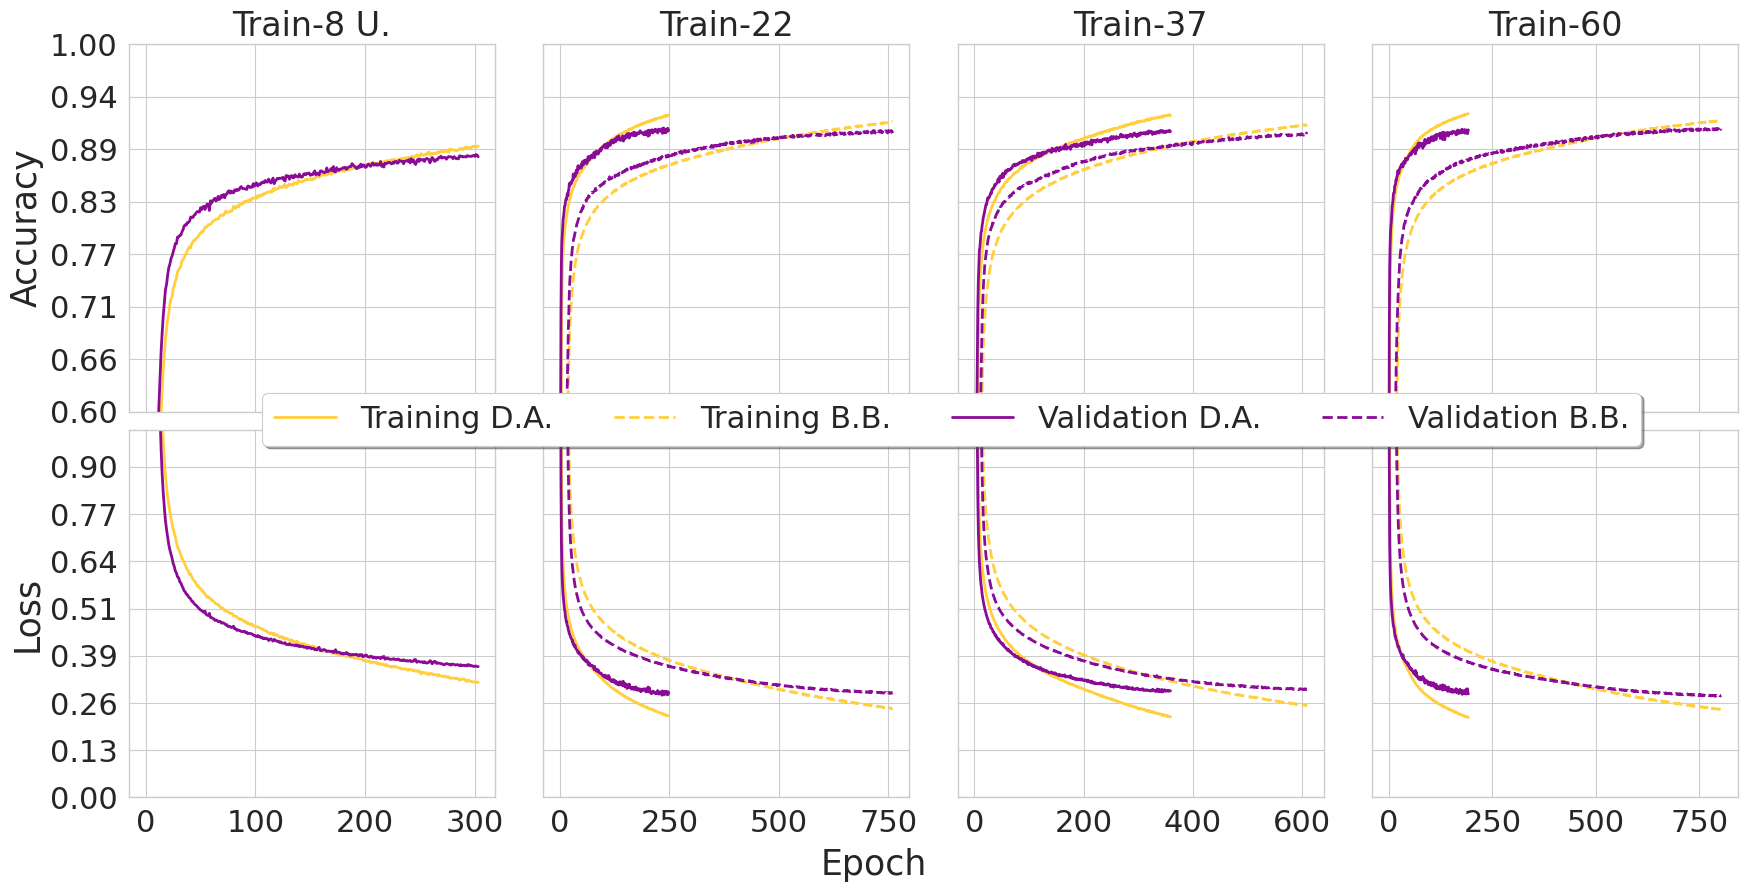

In [19]:
amarillo_train = "#FFCF3D"
purpura_val = "#890B96"
file_names = ['history_softmax_Number_CEP', 'history_softmax_Number_DST', 'history_softmax_Number_ELL', 'history_softmax_Number_M']

title_names = [
    'Train-8 U.',
    'Train-22',
    'Train-37',
    "Train-60"]
plot_accuracy_and_loss(path,file_names, title_names, amarillo_train, purpura_val,f"{path}/training.pdf")

## Test time 

In [126]:
data = h5py.File(f"{path}/Data.hdf5", 'r+')
model = make_model()
prueba = "training_softmax_Number_DST"
model.load_weights(f"{path}/{prueba}/cp.ckpt")


In [158]:
tiempo = []
for i in range(1000):
    t0 = time.time()
    model.predict(data["Number_CEP_data"][:1000])
    tiempo.append(time.time()-t0)

### Acc, Rec, F1

In [4]:
tests = ['training_softmax_Number_CEP','training_softmax_Number_ELL', 'training_softmax_batchBalanced_Number_ELL','training_softmax_Number_DST', 'training_softmax_batchBalanced_Number_DST', 'training_softmax_Number_M', 'training_softmax_batchBalanced_Number_M']


In [29]:
acc,f1,rec,prec = metrics_per_model(tests,"Number_CEP",path)

In [31]:
df = pd.DataFrame({"name":tests,"acc":acc,"f1":f1,"rec":rec,"prec":prec})

In [38]:
print(pd.DataFrame({"name":tests,"acc":acc,"f1":f1,"rec":rec,"prec":prec}).round(3).to_latex())

\begin{tabular}{llrrrr}
\toprule
 & name & acc & f1 & rec & prec \\
\midrule
0 & training_softmax_Number_CEP & 0.890000 & 0.890000 & 0.890000 & 0.891000 \\
1 & training_softmax_Number_ELL & 0.911000 & 0.911000 & 0.911000 & 0.912000 \\
2 & training_softmax_batchBalanced_Number_ELL & 0.908000 & 0.908000 & 0.908000 & 0.909000 \\
3 & training_softmax_Number_DST & 0.913000 & 0.913000 & 0.913000 & 0.915000 \\
4 & training_softmax_batchBalanced_Number_DST & 0.911000 & 0.911000 & 0.911000 & 0.912000 \\
5 & training_softmax_Number_M & 0.916000 & 0.916000 & 0.916000 & 0.918000 \\
6 & training_softmax_batchBalanced_Number_M & 0.916000 & 0.916000 & 0.916000 & 0.917000 \\
\bottomrule
\end{tabular}



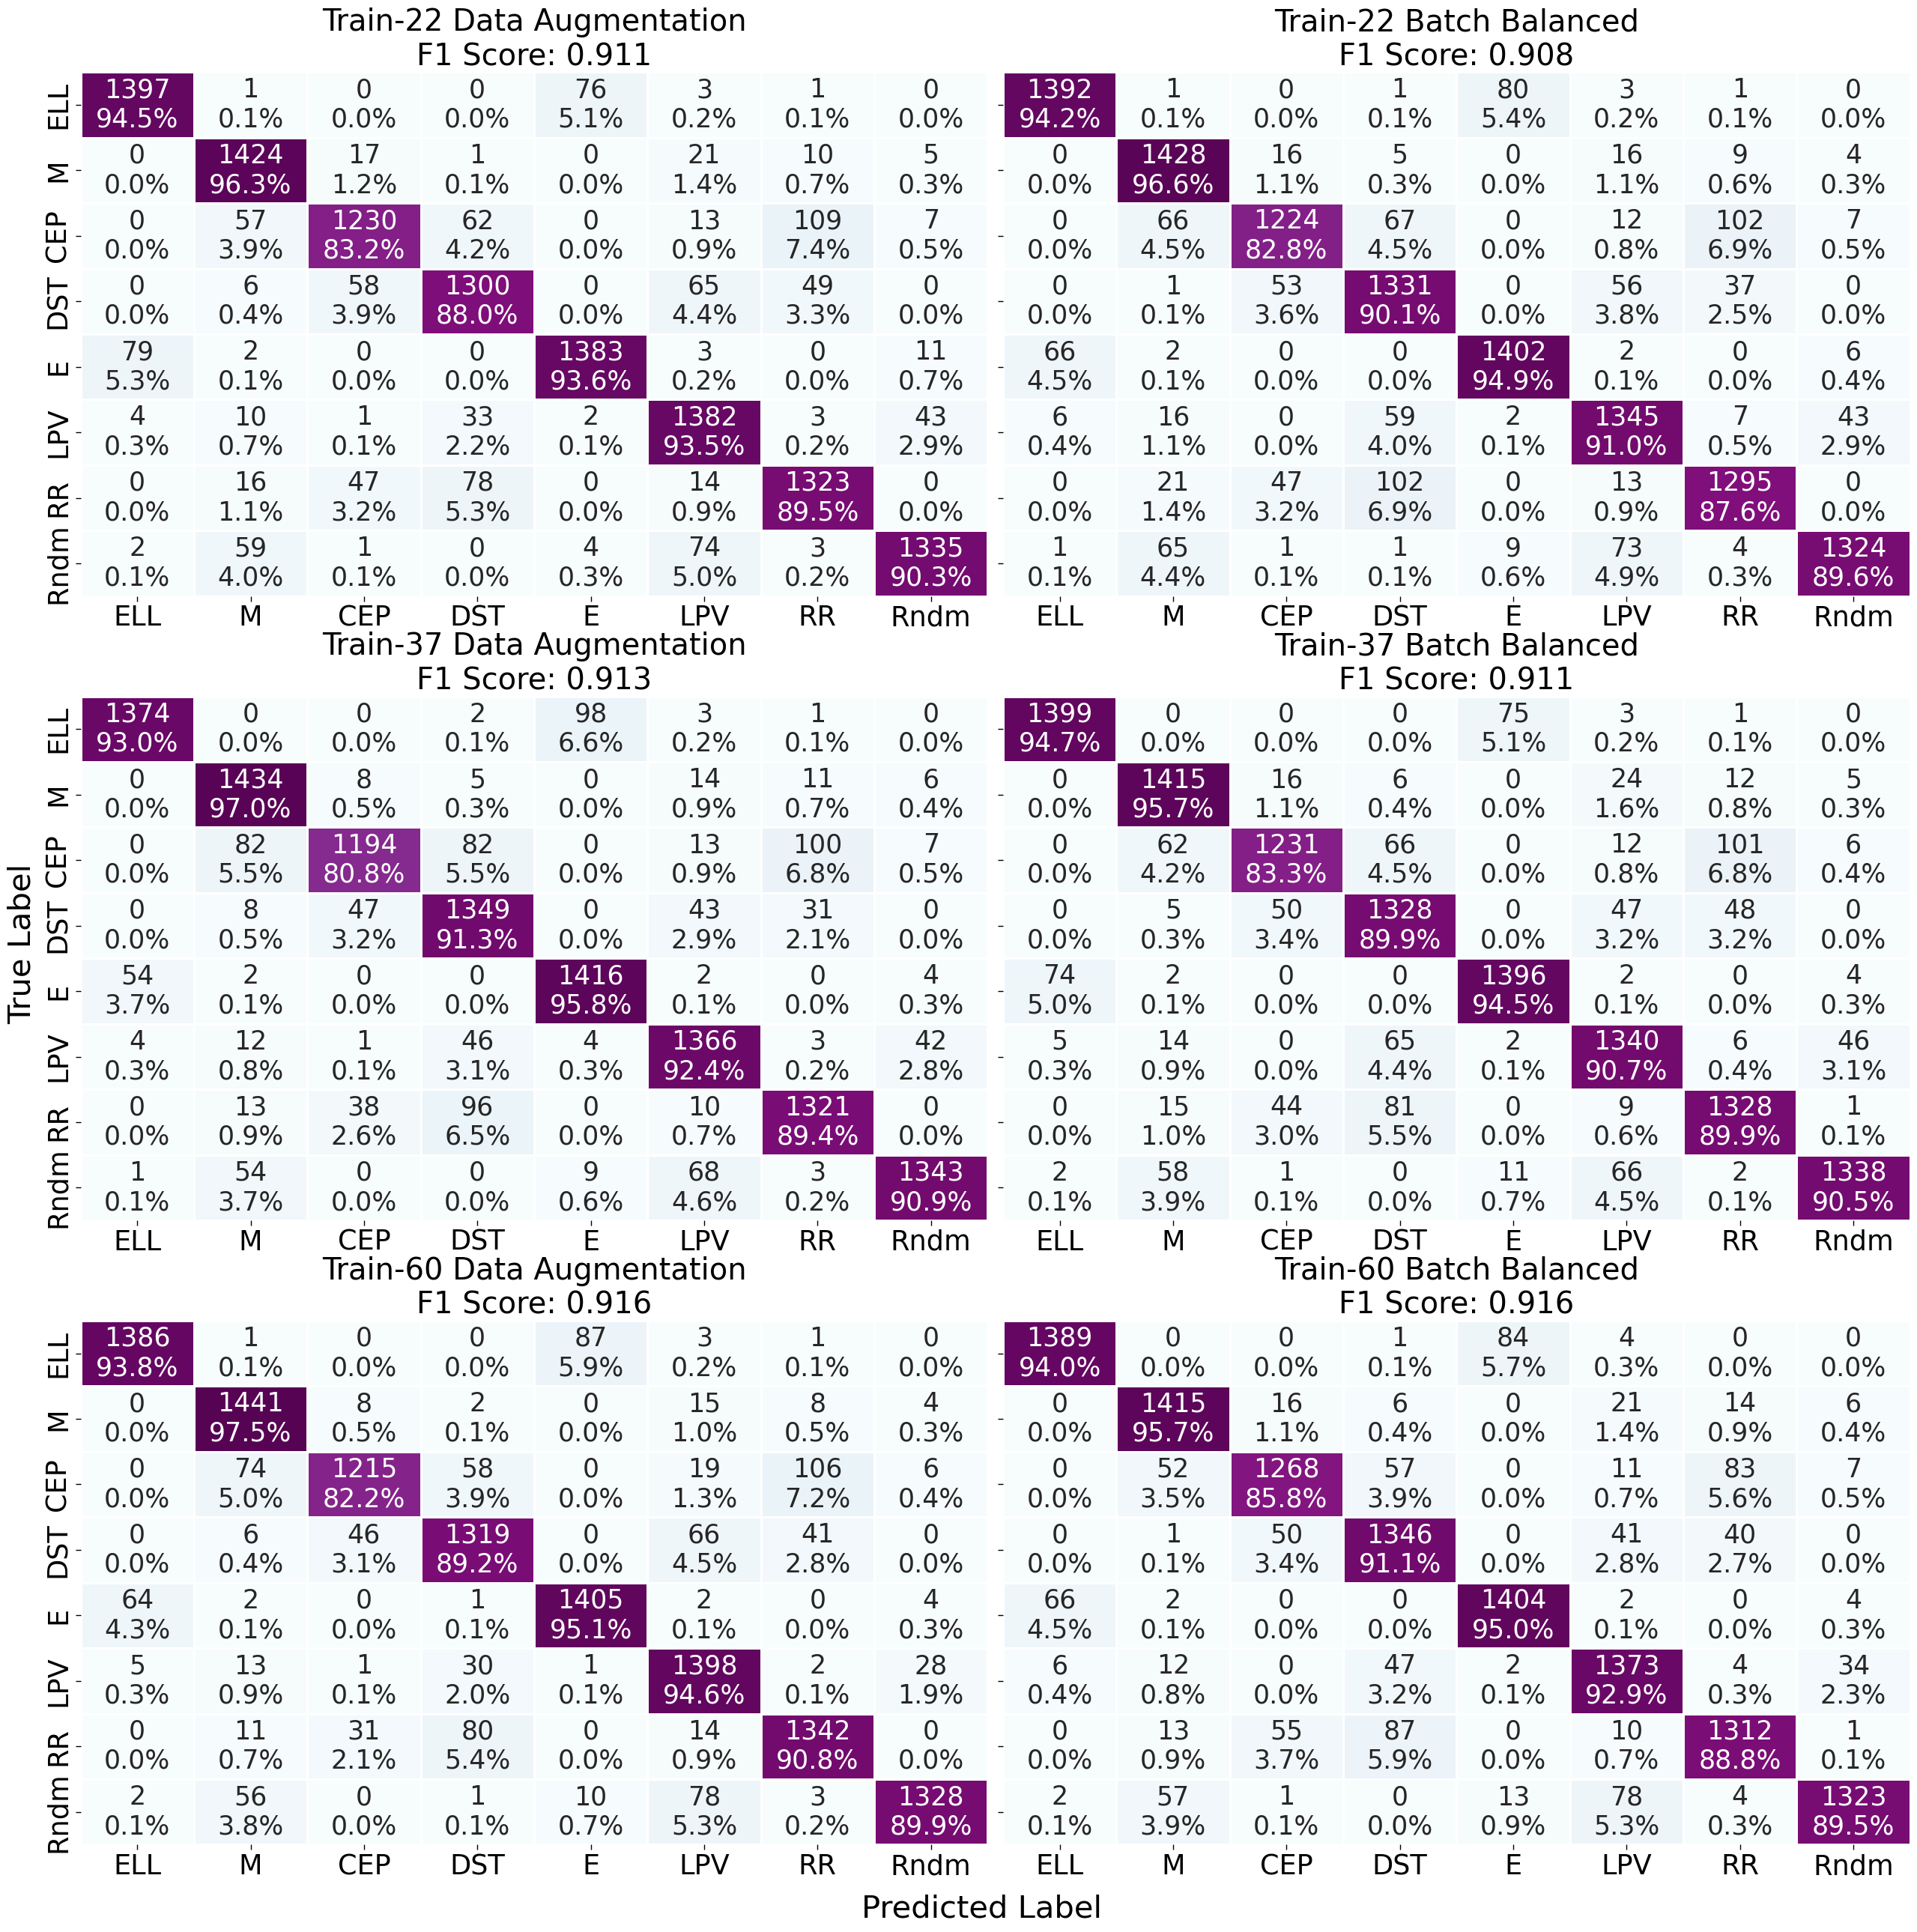

In [101]:
tests = ['training_softmax_Number_ELL', 'training_softmax_batchBalanced_Number_ELL','training_softmax_Number_DST', 'training_softmax_batchBalanced_Number_DST', 'training_softmax_Number_M', 'training_softmax_batchBalanced_Number_M']
titles = ['Train-22 Data Augmentation',
         'Train-22 Batch Balanced','Train-37 Data Augmentation',
         'Train-37 Batch Balanced',
         'Train-60 Data Augmentation',
         'Train-60 Batch Balanced']

test = run_analysis(tests,titles,"Number_CEP",path)

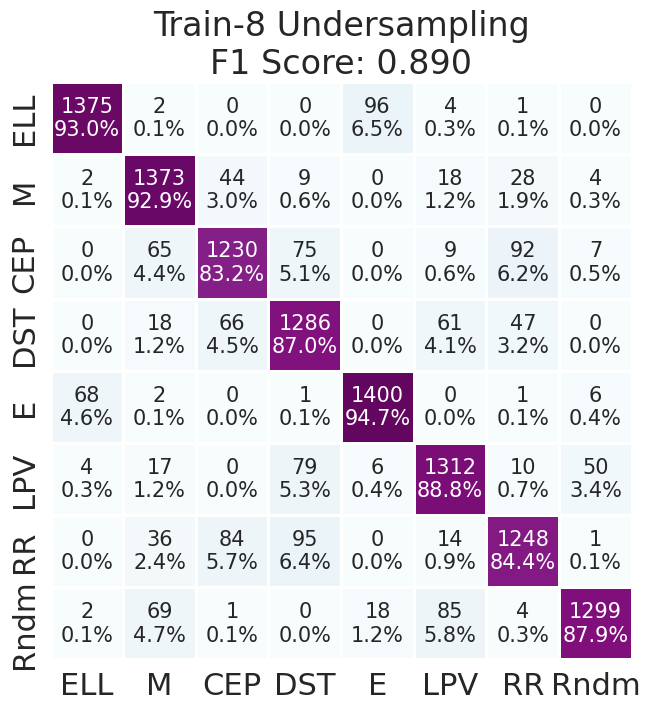

In [75]:
test_under = undersampling_CM("training_softmax_Number_CEP",'Train-8 Undersampling',"Number_CEP",path)

In [102]:
df = metricas(test["categorical_label"],test["label_predict_training_softmax_batchBalanced_Number_M"])

Accuracy: 0.92
macro precision:  0.92
macro recall:  0.92
macro F1:  0.92
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1478
           1       0.91      0.96      0.93      1478
           2       0.91      0.86      0.88      1478
           3       0.87      0.91      0.89      1478
           4       0.93      0.95      0.94      1478
           5       0.89      0.93      0.91      1478
           6       0.90      0.89      0.89      1478
           7       0.96      0.90      0.93      1478

    accuracy                           0.92     11824
   macro avg       0.92      0.92      0.92     11824
weighted avg       0.92      0.92      0.92     11824



In [9]:
print(pd.DataFrame(df).round(3).T.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.949000 & 0.940000 & 0.945000 & 1478.000000 \\
1 & 0.912000 & 0.957000 & 0.934000 & 1478.000000 \\
2 & 0.912000 & 0.858000 & 0.884000 & 1478.000000 \\
3 & 0.872000 & 0.911000 & 0.891000 & 1478.000000 \\
4 & 0.934000 & 0.950000 & 0.942000 & 1478.000000 \\
5 & 0.892000 & 0.929000 & 0.910000 & 1478.000000 \\
6 & 0.900000 & 0.888000 & 0.894000 & 1478.000000 \\
7 & 0.962000 & 0.895000 & 0.927000 & 1478.000000 \\
accuracy & 0.916000 & 0.916000 & 0.916000 & 0.916000 \\
macro avg & 0.917000 & 0.916000 & 0.916000 & 11824.000000 \\
weighted avg & 0.917000 & 0.916000 & 0.916000 & 11824.000000 \\
\bottomrule
\end{tabular}



## Time to Run RF + CNN

In [24]:
test = 'training_softmax_batchBalanced_Number_M'
test_data_name =  'Number_CEP'

In [25]:
data = h5py.File(f"{path}Data.hdf5", 'r+')
#ogle = pd.read_csv("catalogos/ogle_no_usado.csv")
df_8mil = pd.read_csv(f"{path}prueba_8mil.csv")
idx_test = df_8mil.loc[df_8mil["Train_8"]=="test"].index.values
model_softmax = make_model()
model_softmax.load_weights(f"{path}{test}/cp.ckpt")

In [27]:
t0 = time.time()
df = pd.DataFrame(model_softmax.predict(data[f"{test_data_name}_data"][:]),columns=['ELL', 'M', 'CEP', 'DST', 'E', 'LPV', 'RR',"Rndm"])
df_8mil = pd.concat([df_8mil,df],axis=1)
df_8mil = df_8mil.loc[df_8mil["categorical_label"]!=7]
X_train = df_8mil.loc[df_8mil["Train_8"]!="test"][['ELL', 'M', 'CEP', 'DST', 'E', 'LPV', 'RR',"Rndm",
         "per","amplitud","types","categorical_label"]]
X_test = df_8mil.loc[df_8mil["Train_8"]=="test"][['ELL', 'M', 'CEP', 'DST', 'E', 'LPV', 'RR',"Rndm",
         "per","amplitud","types","categorical_label"]]
t1 = time.time() - t0

2842/2842 [==============================] - 3s 1ms/step


In [31]:
clf = RandomForestClassifier(n_estimators=10, random_state=42)    
    # Entrena el clasificador
t0 = time.time()
clf.fit(X_train.drop(columns={"types","categorical_label"}), X_train["categorical_label"])
t1 = time.time() - t0

In [32]:
t1

1.4833238124847412

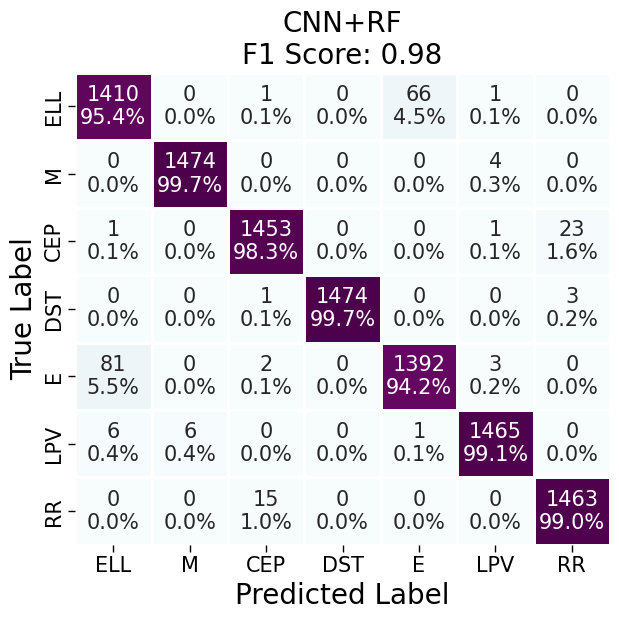

In [82]:
y_pred = train_random_forest(X_train.drop(columns={"types","categorical_label"}),
                   X_train["categorical_label"],
                   X_test.drop(columns={"types","categorical_label"}),
                   X_test["categorical_label"],path,10)